<a href="https://colab.research.google.com/github/cheneeheng/Transformer-TF/blob/colab_dev/Cifar10_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 Classification**

Based on [CIFAR10_Keras_GPU.ipynb](https://github.com/katnoria/cifar10-native-vs-colab/blob/master/CIFAR10_Keras_GPU.ipynb) from [katnoria/cifar10-native-vs-colab](https://github.com/katnoria/cifar10-native-vs-colab) .

General info about the dataset:
- 50K Train, 10K Test
- 10 object classes


# Imports

In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

SAVE_PATH = "/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_"

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
tf.__version__

'2.4.1'

# Data generator

In [2]:
from tensorflow.keras.datasets import cifar10

(x_trn_full, y_trn_full), (x_tst, y_tst) = cifar10.load_data()

# remove the last dimension
y_trn_full = y_trn_full.reshape(y_trn_full.shape[0],)
y_tst = y_tst.reshape(y_tst.shape[0],)

# perform in model.
# # normalize data to 0..1
# x_trn_full, x_tst = x_trn_full / 255.0, x_tst / 255.0

# create validation split
# split = 0.2
# x_trn, x_val, y_trn, y_val = train_test_split(
#     x_trn_full, y_trn_full, test_size=split, random_state=1969)
x_trn, x_val, y_trn, y_val = x_trn_full, x_tst, y_trn_full, y_tst

print(f'x_trn.shape: {x_trn.shape}')
print(f'y_trn.shape: {y_trn.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'x_tst shape: {x_tst.shape}')
print(f'y_tst.shape: {y_tst.shape}')

170500096/170498071 [==============================] - 2s 0us/step
x_trn.shape: (50000, 32, 32, 3)
y_trn.shape: (50000,)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000,)
x_tst shape: (10000, 32, 32, 3)
y_tst.shape: (10000,)


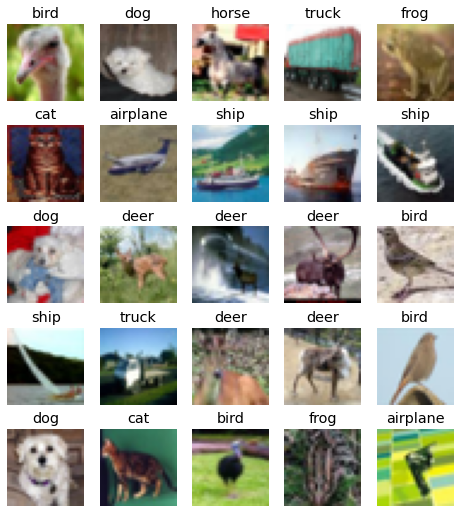

In [3]:
# pick 25 random images and plot
idxs = np.random.randint(x_trn.shape[0], size=25)
images = x_trn[idxs]
labels = y_trn[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
plt.show()

In [4]:
class Patches(tf.keras.layers.Layer):
  """Creates patches from an image. Implemented as a keras layer."""
  def __init__(self, patch_size: int):
    super().__init__()
    self.patch_size = patch_size

  def call(self, x):
    batch_size = tf.shape(x)[0]
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

  def get_config(self):
    return {"patch_size": self.patch_size}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


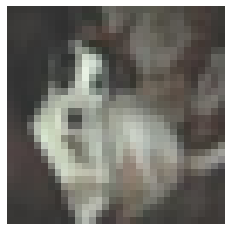

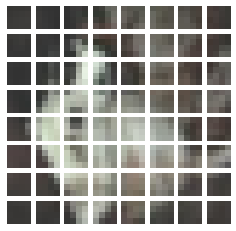

In [5]:
plt.figure(figsize=(4, 4))
image = x_trn[np.random.choice(range(x_trn.shape[0]))]
plt.imshow(image)
plt.axis("off")

image_size = 32
patch_size = 4

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [6]:
def data_generator(split: str, batch_size: int, shuffle_buffer: int = 10000):
  """Creates a tf.data.Dataset instance.

  Args:
      split: The type of data to generate, ['train', 'val', 'test'].
      batch_size: Batch size.
      shuffle_buffer: Number of elements used for shuffling.

  Returns:
      A tf.data.Dataset instance.

  Raises:
      ValueError: If `split` is not ['train', 'val', 'test'].

  """
  if split == 'train':
    ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
    ds = ds.shuffle(shuffle_buffer)
  elif split == 'val':
    ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  elif split == 'test':
    ds = tf.data.Dataset.from_tensor_slices((x_tst, y_tst))
  else:
    raise ValueError(f"Unknown data split : {split}")
  return ds.batch(batch_size)

# Model

A simple CNN example from the keras [CNN benchmark](https://github.com/keras-team/keras/blob/master/keras/benchmarks/keras_examples_benchmarks/cifar10_cnn_benchmark_test.py) .  
It is based on this [CNN example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) but the example is no longer available.


In [7]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Conv2D, 
  BatchNormalization, 
  MaxPool2D,
  Dropout,
  Flatten,
  Dense
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu
from tensorflow.keras.layers.experimental.preprocessing import (
  RandomFlip,
  RandomTranslation,
  RandomRotation,
  RandomZoom,
  Normalization,
  Rescaling,
  Resizing
)

def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
  return Conv2D(filters, 
                kernel_size, 
                strides, 
                padding=padding, 
                activation=relu,
                **kwargs)
  
def maxpool2d(**kwargs):
  return MaxPool2D([3, 3], 2, padding='valid', **kwargs)

class SmallCNN(Model):
  """SmallCNN implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """

  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               preprocess: bool = False):
    super().__init__()

    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = conv2d(32, 3, name='conv2')
    self.pool2 = maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')
    self.conv3 = conv2d(64, 3, name='conv3', padding='same')
    self.conv4 = conv2d(64, 3, name='conv4')
    self.pool4 = maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')
    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.dens6 = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)
    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)
    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)
    x = self.pool4(self.conv4(self.conv3(x)))
    x = self.drop4(x, training=training)
    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.dens6(x)
    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
    return {"num_classes": self.num_classes,
            "image_height": self.image_height,
            "image_width": self.image_width,
            "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
    return cls(**config)

[Vision Transformer](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al.  
Code taken from this [example](https://keras.io/examples/vision/image_classification_with_vision_transformer/) .

In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Layer,
  Add,
  BatchNormalization, 
  Conv2D, 
  Dense,
  Dropout,
  Embedding,
  Flatten,
  LayerNormalization,
  MaxPool2D,
  MultiHeadAttention
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, gelu
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)

def mlp(hidden_units: list, dropout_rate: float, name: str = ''):
  """Multilayer perceptron."""
  layers = []
  for idx, units in enumerate(hidden_units):
    layers.append(Dense(units, activation=gelu, name=f'{name}/dens{idx}'))
    layers.append(Dropout(dropout_rate, name=f'{name}/drop{idx}'))
  return layers

class MLP(Layer):
  """Multilayer perceptron."""
  def __init__(self, hidden_units: list, dropout_rate: float):
    super().__init__()
    self.hidden_units = hidden_units
    self.dropout_rate = dropout_rate
    
    self.layers = []
    self.dropouts = []
    for idx, units in enumerate(self.hidden_units):
      self.layers.append(Dense(units, activation=gelu, name=f'dens{idx}'))
      self.dropouts.append(Dropout(dropout_rate))

  def call(self, x, training: bool = None):
    for layer_i, dropout_i in zip(self.layers, self.dropouts):
        x = layer_i(x)
        x = dropout_i(x, training=training)
    return x
  
  def get_config(self):
    return {"hidden_units": self.hidden_units,
            "dropout_rate": self.dropout_rate}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class PatchEncoder(Layer):
  """Encoder for the image patches."""
  def __init__(self, num_patches: int, projection_dim: int):
    super().__init__()
    self.num_patches = num_patches
    self.projection_dim = projection_dim
    self.projection = Dense(units=self.projection_dim)
    self.position_embedding = Embedding(input_dim=num_patches,
                                        output_dim=self.projection_dim)

  def call(self, x):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(x) + self.position_embedding(positions)
    return encoded
  
  def get_config(self):
    return {"num_patches": self.num_patches,
            "projection_dim": self.projection_dim}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class VIT(Model):
  """Vision Transformer implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               patch_size: int, 
               projection_dim: int,
               num_layers: int,
               num_heads: int,
               mlp_dims: list,
               classifier_mlp_dims: list,
               preprocess: bool = False):
    super().__init__()
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.patch_size = patch_size
    self.projection_dim = projection_dim
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.mlp_dims = mlp_dims
    self.classifier_mlp_dims = classifier_mlp_dims
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Patches
    self.patch = Patches(self.patch_size)
    num_patches = (self.image_height // self.patch_size) * \
                  (self.image_width // self.patch_size)
    self.patch_enc = PatchEncoder(num_patches, self.projection_dim)

    # Model
    self.transformer_blocks = []
    for idx in range(self.num_layers):
      block = []
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_1')]
      block += [MultiHeadAttention(self.num_heads, 
                                   self.projection_dim, 
                                   dropout=0.1, 
                                   name=f'mha{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_1')]
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_2')]
      block += [mlp(mlp_dims, dropout_rate=0.1, name=f'mlp{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_2')]
      self.transformer_blocks.append(block)

    self.lnorm = LayerNormalization(epsilon=1e-6, name='classifier_ln')
    self.flat = Flatten(name='classifier_flat')
    self.drop = Dropout(0.5, name='classifier_drop')
    self.mlp = mlp(self.classifier_mlp_dims, dropout_rate=0.5, 
                   name='classifier_mlp')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.patch(x)
    x = self.patch_enc(x)
    
    for block in self.transformer_blocks:
      x_layer_norm_1 = block[0](x)
      x_attention    = block[1](x_layer_norm_1, x_layer_norm_1)
      x_skip         = block[2]([x_attention, x])
      x_layer_norm_2 = block[3](x_skip)
      x_mlp          = self._iterate_mlp(block[4], x_layer_norm_2)
      x              = block[5]([x_mlp, x_skip])
    
    x = self.lnorm(x)
    x = self.flat(x)
    x = self.drop(x, training=training)
    x = self._iterate_mlp(self.mlp, x)
    x = self.logits(x)
    return x
  
  @staticmethod
  def _iterate_mlp(mlp_layers: list, x: tf.Tensor):
    _x = x
    for mlp_i in mlp_layers:
      _x = mlp_i(_x)
    return _x

  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

Save an initial copy of the weights.  
The weights will be used to initialize all the experiments, allowing for fair comparison.


In [9]:
%%script false 
# Kept as reference.

# # Saves a full copy of the model.
# model_SmallCNN = SmallCNN(num_classes=10, 
#                           image_height=32, 
#                           image_width=32,
#                           preprocess=False).model()
# model_SmallCNN.save('model_SmallCNN')

# # Loads model
# model_SmallCNN = tf.keras.models.load_model('model_SmallCNN')
# model_SmallCNN.summary()

# # Saves a full copy of the model.
# model_VIT = VIT(num_classes=10, 
#                 image_height=32, 
#                 image_width=32,
#                 patch_size=4, 
#                 projection_dim=32,
#                 num_layers=4,
#                 num_heads=4,
#                 mlp_dims=[64, 32],
#                 classifier_mlp_dims=[512],
#                 preprocess=False).model()
# model_VIT.save('model_VIT')

# # Loads model
# model_VIT = tf.keras.models.load_model('model_VIT')
# model_VIT.summary()

# # Saves only the weights of the model.
# model = SmallCNN(num_classes=10)
# model(tf.zeros([1,32,32,3]))
# model.save_weights('model.h5')

# # Loads weights
# model.load_weights('model.h5')
# model.preprocess = True
# for layer in model.model().layers:
#   print(layer.output)
# model.model().summary()

# Train

Training configs.

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy
batch_size = 256
shuffle_buffer = 50000
epochs = 50
learning_rate = 1e-3

num_classes = 10 
image_height = 32
image_width = 32

Keras model.compile(...) and model.fit(...) .


In [11]:
def train_and_eval(_model, _checkpoint_filepath):
  """Wrapper code for training and evaluating.

  Args:
      _model: A keras Model.
      _checkpoint_filepath: Path to save a checkpoint.

  Returns:
      A history instance that contains logged values per epoch.

  """
  _model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_fn,
    metrics=[acc_metric_fn(name='sparse_categorical_accuracy')]
  )

  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    _checkpoint_filepath,
    monitor="val_sparse_categorical_accuracy",
    save_best_only=True,
  )

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join(_checkpoint_filepath, 'logs'), 
    histogram_freq=epochs//10,
    update_freq='epoch'
  )

  start = time()
  history = _model.fit(
      data_generator('train', batch_size, shuffle_buffer), 
      epochs=epochs, 
      steps_per_epoch=len(data_generator('train', batch_size, shuffle_buffer)),
      validation_data=data_generator('val', batch_size),
      callbacks=[tensorboard_callback, checkpoint_callback],
  )
  end = time()
  print(f'Total training time {end - start} seconds')
  
  # Save history output, should be the same as the tensorboard logs.
  np.save(os.path.join(_checkpoint_filepath, 'history.npy'), history.history)

  return history

Native TF with GradientTape.  
This is exactly the same as using compite(...) and fit(...) in keras.  
However, this exposes the gradient and the train loop, allowing for more flexibility.

In [12]:
%%script false
# This is just for reference.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = acc_metric_fn(name='sparse_categorical_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = acc_metric_fn(name='val_sparse_categorical_accuracy')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  # Container to keep the results.
  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def val_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  v_loss = loss_fn(labels, predictions)
  # Container to keep the results.
  val_loss(v_loss)
  val_accuracy(labels, predictions)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
progbar = tf.keras.utils.Progbar
trn_ds = data_generator('train', batch_size, shuffle_buffer)
val_ds = data_generator('val', batch_size)

start = time()
for epoch in range(epochs):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  print(f"Epoch {epoch+1}/{epochs}")
  pb_i = progbar(steps_per_epoch=len(trn_ds), 
                 stateful_metrics=['Loss', 'Accuracy',
                                   'Val Loss', 'Val Accuracy'])
  
  for idx, (images, labels) in enumerate(trn_ds):
    train_step(images, labels)
    if idx + 1 < mini_batches:
      pb_i.add(1, values=[('Loss', train_loss.result()), 
                          ('Accuracy', train_accuracy.result())])

  for val_images, val_labels in val_ds:
    val_step(val_images, val_labels)
  pb_i.add(1, values=[('Loss', train_loss.result()), 
                      ('Accuracy', train_accuracy.result()),
                      ('Val Loss', val_loss.result()), 
                      ('Val Accuracy', val_accuracy.result())])

  train_losses.append(train_loss.result())
  train_accuracies.append(train_accuracy.result())
  val_losses.append(val_loss.result())
  val_accuracies.append(val_accuracy.result())

end = time()

print(f'Total training time {end - start} seconds')

# Loss and accuracy plots

In [13]:
def plot(losses: list, 
         accuracies: list, 
         legend_labels: list, 
         subplot_title: list):
  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  
  for x, ll in zip(losses, legend_labels):
    c = ax1.plot(x[0], label='Trn: ' + ll, linestyle='--')[0].get_c()
    _ = ax1.plot(x[1], label='Val: ' + ll, linestyle='-', color=c)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  ax1.legend()   

  for x, ll in zip(accuracies, legend_labels):
    c = ax2.plot(x[0], label='Trn: ' + ll, linestyle='--')[0].get_c()
    _ = ax2.plot(x[1], label='Val: ' + ll, linestyle='-', color=c)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
  ax2.legend()   

  plt.show()

#Experiments

**Experiment 1**  
Model : CNN  
Preprocessing : False  
Batch size : 256

In [14]:
model = SmallCNN(num_classes=num_classes, 
                 image_height=image_height, 
                 image_width=image_width,
                 preprocess=False).model()
model.summary()
history_cnn = train_and_eval(model, SAVE_PATH + 'CNN')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0     

**Experiment 2**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4

In [15]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=4,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4 = train_and_eval(model, SAVE_PATH + 'VIT_4x4')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 2/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7753 - sparse_categorical_accuracy: 0.3464 - val_loss: 1.4740 - val_sparse_categorical_accuracy: 0.4621


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 3/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5924 - sparse_categorical_accuracy: 0.4137 - val_loss: 1.3894 - val_sparse_categorical_accuracy: 0.4872


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 4/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5011 - sparse_categorical_accuracy: 0.4550 - val_loss: 1.3193 - val_sparse_categorical_accuracy: 0.5237


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 5/50
196/196 [==============================] - 9s 44ms/step - loss: 1.4245 - sparse_categorical_accuracy: 0.4804 - val_loss: 1.2597 - val_sparse_categorical_accuracy: 0.5389


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 6/50
196/196 [==============================] - 9s 44ms/step - loss: 1.3823 - sparse_categorical_accuracy: 0.4988 - val_loss: 1.2415 - val_sparse_categorical_accuracy: 0.5416


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 7/50
196/196 [==============================] - 9s 45ms/step - loss: 1.3345 - sparse_categorical_accuracy: 0.5167 - val_loss: 1.2058 - val_sparse_categorical_accuracy: 0.5587


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 8/50
196/196 [==============================] - 9s 45ms/step - loss: 1.2873 - sparse_categorical_accuracy: 0.5348 - val_loss: 1.1705 - val_sparse_categorical_accuracy: 0.5733


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 9/50
196/196 [==============================] - 9s 45ms/step - loss: 1.2330 - sparse_categorical_accuracy: 0.5558 - val_loss: 1.1162 - val_sparse_categorical_accuracy: 0.5967


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 10/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1967 - sparse_categorical_accuracy: 0.5711 - val_loss: 1.1207 - val_sparse_categorical_accuracy: 0.5954
Epoch 11/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1839 - sparse_categorical_accuracy: 0.5761 - val_loss: 1.0964 - val_sparse_categorical_accuracy: 0.5977


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 12/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1406 - sparse_categorical_accuracy: 0.5918 - val_loss: 1.0635 - val_sparse_categorical_accuracy: 0.6183


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 13/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1106 - sparse_categorical_accuracy: 0.6037 - val_loss: 1.0558 - val_sparse_categorical_accuracy: 0.6255


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 14/50
196/196 [==============================] - 9s 44ms/step - loss: 1.0933 - sparse_categorical_accuracy: 0.6100 - val_loss: 1.0210 - val_sparse_categorical_accuracy: 0.6308


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 15/50
196/196 [==============================] - 9s 44ms/step - loss: 1.0635 - sparse_categorical_accuracy: 0.6213 - val_loss: 1.0228 - val_sparse_categorical_accuracy: 0.6326


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 16/50
196/196 [==============================] - 9s 44ms/step - loss: 1.0566 - sparse_categorical_accuracy: 0.6236 - val_loss: 0.9956 - val_sparse_categorical_accuracy: 0.6411


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 17/50
196/196 [==============================] - 9s 45ms/step - loss: 1.0250 - sparse_categorical_accuracy: 0.6311 - val_loss: 0.9864 - val_sparse_categorical_accuracy: 0.6452


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 18/50
196/196 [==============================] - 9s 45ms/step - loss: 1.0000 - sparse_categorical_accuracy: 0.6446 - val_loss: 0.9862 - val_sparse_categorical_accuracy: 0.6488


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 19/50
196/196 [==============================] - 9s 44ms/step - loss: 0.9862 - sparse_categorical_accuracy: 0.6479 - val_loss: 0.9617 - val_sparse_categorical_accuracy: 0.6547


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 20/50
196/196 [==============================] - 9s 44ms/step - loss: 0.9562 - sparse_categorical_accuracy: 0.6598 - val_loss: 0.9459 - val_sparse_categorical_accuracy: 0.6635


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 21/50
196/196 [==============================] - 9s 44ms/step - loss: 0.9370 - sparse_categorical_accuracy: 0.6671 - val_loss: 0.9366 - val_sparse_categorical_accuracy: 0.6673


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 22/50
196/196 [==============================] - 9s 44ms/step - loss: 0.9234 - sparse_categorical_accuracy: 0.6715 - val_loss: 0.9429 - val_sparse_categorical_accuracy: 0.6568
Epoch 23/50
196/196 [==============================] - 9s 44ms/step - loss: 0.9062 - sparse_categorical_accuracy: 0.6776 - val_loss: 0.9427 - val_sparse_categorical_accuracy: 0.6620
Epoch 24/50
196/196 [==============================] - 9s 44ms/step - loss: 0.8979 - sparse_categorical_accuracy: 0.6797 - val_loss: 0.8971 - val_sparse_categorical_accuracy: 0.6789


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 25/50
196/196 [==============================] - 9s 44ms/step - loss: 0.8668 - sparse_categorical_accuracy: 0.6908 - val_loss: 0.9031 - val_sparse_categorical_accuracy: 0.6801


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 26/50
196/196 [==============================] - 9s 44ms/step - loss: 0.8519 - sparse_categorical_accuracy: 0.6964 - val_loss: 0.9144 - val_sparse_categorical_accuracy: 0.6786
Epoch 27/50
196/196 [==============================] - 9s 44ms/step - loss: 0.8270 - sparse_categorical_accuracy: 0.7093 - val_loss: 0.8887 - val_sparse_categorical_accuracy: 0.6917


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 28/50
196/196 [==============================] - 9s 44ms/step - loss: 0.8177 - sparse_categorical_accuracy: 0.7079 - val_loss: 0.8692 - val_sparse_categorical_accuracy: 0.6888
Epoch 29/50
196/196 [==============================] - 9s 44ms/step - loss: 0.8054 - sparse_categorical_accuracy: 0.7144 - val_loss: 0.8763 - val_sparse_categorical_accuracy: 0.6882
Epoch 30/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7990 - sparse_categorical_accuracy: 0.7161 - val_loss: 0.8691 - val_sparse_categorical_accuracy: 0.7007


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 31/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7762 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.8512 - val_sparse_categorical_accuracy: 0.6975
Epoch 32/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7677 - sparse_categorical_accuracy: 0.7250 - val_loss: 0.8500 - val_sparse_categorical_accuracy: 0.7001
Epoch 33/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7715 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.8763 - val_sparse_categorical_accuracy: 0.6925
Epoch 34/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7632 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.8393 - val_sparse_categorical_accuracy: 0.7038


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 35/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7285 - sparse_categorical_accuracy: 0.7387 - val_loss: 0.8596 - val_sparse_categorical_accuracy: 0.6984
Epoch 36/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7061 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.8494 - val_sparse_categorical_accuracy: 0.7006
Epoch 37/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7139 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.8265 - val_sparse_categorical_accuracy: 0.7037
Epoch 38/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6956 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.8374 - val_sparse_categorical_accuracy: 0.7074


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 39/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6952 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.8362 - val_sparse_categorical_accuracy: 0.7059
Epoch 40/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6791 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.8392 - val_sparse_categorical_accuracy: 0.7052
Epoch 41/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6769 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.8224 - val_sparse_categorical_accuracy: 0.7126


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 42/50
196/196 [==============================] - 9s 45ms/step - loss: 0.6658 - sparse_categorical_accuracy: 0.7660 - val_loss: 0.8249 - val_sparse_categorical_accuracy: 0.7057
Epoch 43/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.7654 - val_loss: 0.8269 - val_sparse_categorical_accuracy: 0.7114
Epoch 44/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6444 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.8270 - val_sparse_categorical_accuracy: 0.7123
Epoch 45/50
196/196 [==============================] - 9s 46ms/step - loss: 0.6315 - sparse_categorical_accuracy: 0.7737 - val_loss: 0.8287 - val_sparse_categorical_accuracy: 0.7123
Epoch 46/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.7753 - val_loss: 0.8099 - val_sparse_categorical_accuracy: 0.7186


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 47/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6243 - sparse_categorical_accuracy: 0.7787 - val_loss: 0.8029 - val_sparse_categorical_accuracy: 0.7173
Epoch 48/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6124 - sparse_categorical_accuracy: 0.7816 - val_loss: 0.8197 - val_sparse_categorical_accuracy: 0.7106
Epoch 49/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6078 - sparse_categorical_accuracy: 0.7852 - val_loss: 0.8096 - val_sparse_categorical_accuracy: 0.7192


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Epoch 50/50
196/196 [==============================] - 9s 44ms/step - loss: 0.5892 - sparse_categorical_accuracy: 0.7932 - val_loss: 0.8045 - val_sparse_categorical_accuracy: 0.7236


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4/assets


Total training time 653.7116007804871 seconds


**Experiment 3**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 16x16

In [16]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=16, 
            projection_dim=32,
            num_layers=4,
            num_heads=4,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_16x16 = train_and_eval(model, SAVE_PATH + 'VIT_16x16')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_2 (Patches)             (None, None, 768)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 2/50
196/196 [==============================] - 3s 16ms/step - loss: 1.8667 - sparse_categorical_accuracy: 0.3200 - val_loss: 1.6711 - val_sparse_categorical_accuracy: 0.4001


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 3/50
196/196 [==============================] - 3s 16ms/step - loss: 1.7516 - sparse_categorical_accuracy: 0.3649 - val_loss: 1.5933 - val_sparse_categorical_accuracy: 0.4326


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 4/50
196/196 [==============================] - 3s 16ms/step - loss: 1.6981 - sparse_categorical_accuracy: 0.3836 - val_loss: 1.5392 - val_sparse_categorical_accuracy: 0.4479


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 5/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6407 - sparse_categorical_accuracy: 0.4107 - val_loss: 1.5131 - val_sparse_categorical_accuracy: 0.4531


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 6/50
196/196 [==============================] - 3s 16ms/step - loss: 1.6046 - sparse_categorical_accuracy: 0.4189 - val_loss: 1.4945 - val_sparse_categorical_accuracy: 0.4621


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 7/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5715 - sparse_categorical_accuracy: 0.4324 - val_loss: 1.4531 - val_sparse_categorical_accuracy: 0.4729


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 8/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5431 - sparse_categorical_accuracy: 0.4470 - val_loss: 1.4394 - val_sparse_categorical_accuracy: 0.4852


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 9/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5101 - sparse_categorical_accuracy: 0.4571 - val_loss: 1.4161 - val_sparse_categorical_accuracy: 0.4900


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 10/50
196/196 [==============================] - 3s 15ms/step - loss: 1.4933 - sparse_categorical_accuracy: 0.4591 - val_loss: 1.4297 - val_sparse_categorical_accuracy: 0.4868
Epoch 11/50
196/196 [==============================] - 3s 15ms/step - loss: 1.4739 - sparse_categorical_accuracy: 0.4715 - val_loss: 1.3848 - val_sparse_categorical_accuracy: 0.4992


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 12/50
196/196 [==============================] - 3s 15ms/step - loss: 1.4707 - sparse_categorical_accuracy: 0.4734 - val_loss: 1.3733 - val_sparse_categorical_accuracy: 0.5075


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 13/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4482 - sparse_categorical_accuracy: 0.4803 - val_loss: 1.3678 - val_sparse_categorical_accuracy: 0.5080


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 14/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4318 - sparse_categorical_accuracy: 0.4848 - val_loss: 1.3764 - val_sparse_categorical_accuracy: 0.5087


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 15/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4280 - sparse_categorical_accuracy: 0.4877 - val_loss: 1.3556 - val_sparse_categorical_accuracy: 0.5125


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 16/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4080 - sparse_categorical_accuracy: 0.4951 - val_loss: 1.3518 - val_sparse_categorical_accuracy: 0.5158


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 17/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3993 - sparse_categorical_accuracy: 0.4981 - val_loss: 1.3823 - val_sparse_categorical_accuracy: 0.5066
Epoch 18/50
196/196 [==============================] - 3s 15ms/step - loss: 1.3794 - sparse_categorical_accuracy: 0.5041 - val_loss: 1.3370 - val_sparse_categorical_accuracy: 0.5175


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 19/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3602 - sparse_categorical_accuracy: 0.5130 - val_loss: 1.3333 - val_sparse_categorical_accuracy: 0.5197


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 20/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3526 - sparse_categorical_accuracy: 0.5138 - val_loss: 1.3394 - val_sparse_categorical_accuracy: 0.5179
Epoch 21/50
196/196 [==============================] - 3s 15ms/step - loss: 1.3380 - sparse_categorical_accuracy: 0.5205 - val_loss: 1.3165 - val_sparse_categorical_accuracy: 0.5319


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 22/50
196/196 [==============================] - 4s 17ms/step - loss: 1.3340 - sparse_categorical_accuracy: 0.5221 - val_loss: 1.3230 - val_sparse_categorical_accuracy: 0.5308
Epoch 23/50
196/196 [==============================] - 3s 15ms/step - loss: 1.3224 - sparse_categorical_accuracy: 0.5291 - val_loss: 1.3096 - val_sparse_categorical_accuracy: 0.5320


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 24/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3142 - sparse_categorical_accuracy: 0.5278 - val_loss: 1.3126 - val_sparse_categorical_accuracy: 0.5283
Epoch 25/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3064 - sparse_categorical_accuracy: 0.5299 - val_loss: 1.3144 - val_sparse_categorical_accuracy: 0.5296
Epoch 26/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3064 - sparse_categorical_accuracy: 0.5315 - val_loss: 1.2953 - val_sparse_categorical_accuracy: 0.5358


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 27/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2836 - sparse_categorical_accuracy: 0.5385 - val_loss: 1.2963 - val_sparse_categorical_accuracy: 0.5334
Epoch 28/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2833 - sparse_categorical_accuracy: 0.5376 - val_loss: 1.3031 - val_sparse_categorical_accuracy: 0.5334
Epoch 29/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2724 - sparse_categorical_accuracy: 0.5425 - val_loss: 1.3117 - val_sparse_categorical_accuracy: 0.5312
Epoch 30/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2587 - sparse_categorical_accuracy: 0.5517 - val_loss: 1.2886 - val_sparse_categorical_accuracy: 0.5370


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 31/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2432 - sparse_categorical_accuracy: 0.5533 - val_loss: 1.2869 - val_sparse_categorical_accuracy: 0.5390


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 32/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2518 - sparse_categorical_accuracy: 0.5494 - val_loss: 1.2867 - val_sparse_categorical_accuracy: 0.5411


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 33/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2394 - sparse_categorical_accuracy: 0.5554 - val_loss: 1.2692 - val_sparse_categorical_accuracy: 0.5503


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 34/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2261 - sparse_categorical_accuracy: 0.5578 - val_loss: 1.2813 - val_sparse_categorical_accuracy: 0.5480
Epoch 35/50
196/196 [==============================] - 3s 15ms/step - loss: 1.2227 - sparse_categorical_accuracy: 0.5619 - val_loss: 1.2875 - val_sparse_categorical_accuracy: 0.5352
Epoch 36/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2121 - sparse_categorical_accuracy: 0.5685 - val_loss: 1.2823 - val_sparse_categorical_accuracy: 0.5445
Epoch 37/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2118 - sparse_categorical_accuracy: 0.5660 - val_loss: 1.2904 - val_sparse_categorical_accuracy: 0.5423
Epoch 38/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2099 - sparse_categorical_accuracy: 0.5688 - val_loss: 1.2715 - val_sparse_categorical_accuracy: 0.5505


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 39/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1954 - sparse_categorical_accuracy: 0.5727 - val_loss: 1.2820 - val_sparse_categorical_accuracy: 0.5445
Epoch 40/50
196/196 [==============================] - 3s 17ms/step - loss: 1.1785 - sparse_categorical_accuracy: 0.5770 - val_loss: 1.2733 - val_sparse_categorical_accuracy: 0.5491
Epoch 41/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1796 - sparse_categorical_accuracy: 0.5763 - val_loss: 1.2785 - val_sparse_categorical_accuracy: 0.5508


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 42/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1743 - sparse_categorical_accuracy: 0.5786 - val_loss: 1.2737 - val_sparse_categorical_accuracy: 0.5488
Epoch 43/50
196/196 [==============================] - 3s 15ms/step - loss: 1.1774 - sparse_categorical_accuracy: 0.5790 - val_loss: 1.2788 - val_sparse_categorical_accuracy: 0.5522


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 44/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1711 - sparse_categorical_accuracy: 0.5831 - val_loss: 1.2917 - val_sparse_categorical_accuracy: 0.5479
Epoch 45/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1584 - sparse_categorical_accuracy: 0.5835 - val_loss: 1.2707 - val_sparse_categorical_accuracy: 0.5537


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 46/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1537 - sparse_categorical_accuracy: 0.5877 - val_loss: 1.2773 - val_sparse_categorical_accuracy: 0.5522
Epoch 47/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1551 - sparse_categorical_accuracy: 0.5856 - val_loss: 1.2809 - val_sparse_categorical_accuracy: 0.5559


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_16x16/assets


Epoch 48/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1425 - sparse_categorical_accuracy: 0.5891 - val_loss: 1.3221 - val_sparse_categorical_accuracy: 0.5361
Epoch 49/50
196/196 [==============================] - 3s 15ms/step - loss: 1.1426 - sparse_categorical_accuracy: 0.5930 - val_loss: 1.2878 - val_sparse_categorical_accuracy: 0.5449
Epoch 50/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1289 - sparse_categorical_accuracy: 0.5960 - val_loss: 1.2697 - val_sparse_categorical_accuracy: 0.5487
Total training time 367.0130352973938 seconds


**Experiment 4**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 8x8

In [17]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=8, 
            projection_dim=32,
            num_layers=4,
            num_heads=4,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_8x8 = train_and_eval(model, SAVE_PATH + 'VIT_8x8')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_3 (Patches)             (None, None, 192)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 2/50
196/196 [==============================] - 4s 18ms/step - loss: 1.8118 - sparse_categorical_accuracy: 0.3313 - val_loss: 1.6289 - val_sparse_categorical_accuracy: 0.4131


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 3/50
196/196 [==============================] - 4s 18ms/step - loss: 1.6507 - sparse_categorical_accuracy: 0.4030 - val_loss: 1.4560 - val_sparse_categorical_accuracy: 0.4671


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 4/50
196/196 [==============================] - 4s 18ms/step - loss: 1.5597 - sparse_categorical_accuracy: 0.4355 - val_loss: 1.3864 - val_sparse_categorical_accuracy: 0.4979


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 5/50
196/196 [==============================] - 4s 18ms/step - loss: 1.5063 - sparse_categorical_accuracy: 0.4580 - val_loss: 1.3480 - val_sparse_categorical_accuracy: 0.5224


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 6/50
196/196 [==============================] - 4s 18ms/step - loss: 1.4480 - sparse_categorical_accuracy: 0.4717 - val_loss: 1.3331 - val_sparse_categorical_accuracy: 0.5218
Epoch 7/50
196/196 [==============================] - 4s 18ms/step - loss: 1.4063 - sparse_categorical_accuracy: 0.4939 - val_loss: 1.2854 - val_sparse_categorical_accuracy: 0.5313


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 8/50
196/196 [==============================] - 4s 18ms/step - loss: 1.3717 - sparse_categorical_accuracy: 0.5058 - val_loss: 1.2547 - val_sparse_categorical_accuracy: 0.5437


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 9/50
196/196 [==============================] - 4s 18ms/step - loss: 1.3336 - sparse_categorical_accuracy: 0.5202 - val_loss: 1.2302 - val_sparse_categorical_accuracy: 0.5522


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 10/50
196/196 [==============================] - 4s 18ms/step - loss: 1.3220 - sparse_categorical_accuracy: 0.5269 - val_loss: 1.2219 - val_sparse_categorical_accuracy: 0.5548


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 11/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2882 - sparse_categorical_accuracy: 0.5376 - val_loss: 1.1898 - val_sparse_categorical_accuracy: 0.5702


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 12/50
196/196 [==============================] - 4s 18ms/step - loss: 1.2605 - sparse_categorical_accuracy: 0.5488 - val_loss: 1.1757 - val_sparse_categorical_accuracy: 0.5759


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 13/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2472 - sparse_categorical_accuracy: 0.5545 - val_loss: 1.1641 - val_sparse_categorical_accuracy: 0.5793


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 14/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2247 - sparse_categorical_accuracy: 0.5606 - val_loss: 1.1555 - val_sparse_categorical_accuracy: 0.5828


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 15/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2177 - sparse_categorical_accuracy: 0.5631 - val_loss: 1.1436 - val_sparse_categorical_accuracy: 0.5898


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 16/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1951 - sparse_categorical_accuracy: 0.5744 - val_loss: 1.1382 - val_sparse_categorical_accuracy: 0.5917


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 17/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1648 - sparse_categorical_accuracy: 0.5854 - val_loss: 1.1312 - val_sparse_categorical_accuracy: 0.5976


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 18/50
196/196 [==============================] - 4s 18ms/step - loss: 1.1610 - sparse_categorical_accuracy: 0.5877 - val_loss: 1.1341 - val_sparse_categorical_accuracy: 0.5978


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 19/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1478 - sparse_categorical_accuracy: 0.5882 - val_loss: 1.1129 - val_sparse_categorical_accuracy: 0.6078


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 20/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1312 - sparse_categorical_accuracy: 0.5944 - val_loss: 1.1109 - val_sparse_categorical_accuracy: 0.6038
Epoch 21/50
196/196 [==============================] - 4s 18ms/step - loss: 1.1224 - sparse_categorical_accuracy: 0.5974 - val_loss: 1.0980 - val_sparse_categorical_accuracy: 0.6055
Epoch 22/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0981 - sparse_categorical_accuracy: 0.6113 - val_loss: 1.0791 - val_sparse_categorical_accuracy: 0.6138


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 23/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0856 - sparse_categorical_accuracy: 0.6106 - val_loss: 1.0715 - val_sparse_categorical_accuracy: 0.6172


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 24/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0953 - sparse_categorical_accuracy: 0.6064 - val_loss: 1.0753 - val_sparse_categorical_accuracy: 0.6214


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 25/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0799 - sparse_categorical_accuracy: 0.6129 - val_loss: 1.0583 - val_sparse_categorical_accuracy: 0.6283


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 26/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0591 - sparse_categorical_accuracy: 0.6188 - val_loss: 1.0670 - val_sparse_categorical_accuracy: 0.6221
Epoch 27/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0508 - sparse_categorical_accuracy: 0.6256 - val_loss: 1.0541 - val_sparse_categorical_accuracy: 0.6264
Epoch 28/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0487 - sparse_categorical_accuracy: 0.6273 - val_loss: 1.0560 - val_sparse_categorical_accuracy: 0.6266
Epoch 29/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0397 - sparse_categorical_accuracy: 0.6295 - val_loss: 1.0608 - val_sparse_categorical_accuracy: 0.6268
Epoch 30/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0167 - sparse_categorical_accuracy: 0.6377 - val_loss: 1.0429 - val_sparse_categorical_accuracy: 0.6286


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 31/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0100 - sparse_categorical_accuracy: 0.6410 - val_loss: 1.0533 - val_sparse_categorical_accuracy: 0.6246
Epoch 32/50
196/196 [==============================] - 4s 18ms/step - loss: 1.0147 - sparse_categorical_accuracy: 0.6393 - val_loss: 1.0498 - val_sparse_categorical_accuracy: 0.6290


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 33/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0069 - sparse_categorical_accuracy: 0.6427 - val_loss: 1.0437 - val_sparse_categorical_accuracy: 0.6322


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 34/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9929 - sparse_categorical_accuracy: 0.6462 - val_loss: 1.0434 - val_sparse_categorical_accuracy: 0.6270
Epoch 35/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9883 - sparse_categorical_accuracy: 0.6461 - val_loss: 1.0335 - val_sparse_categorical_accuracy: 0.6311
Epoch 36/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9722 - sparse_categorical_accuracy: 0.6558 - val_loss: 1.0220 - val_sparse_categorical_accuracy: 0.6355


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 37/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9621 - sparse_categorical_accuracy: 0.6578 - val_loss: 1.0524 - val_sparse_categorical_accuracy: 0.6312
Epoch 38/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9679 - sparse_categorical_accuracy: 0.6516 - val_loss: 1.0081 - val_sparse_categorical_accuracy: 0.6417


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 39/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9521 - sparse_categorical_accuracy: 0.6581 - val_loss: 1.0117 - val_sparse_categorical_accuracy: 0.6425


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 40/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9478 - sparse_categorical_accuracy: 0.6627 - val_loss: 1.0171 - val_sparse_categorical_accuracy: 0.6421
Epoch 41/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9327 - sparse_categorical_accuracy: 0.6651 - val_loss: 1.0066 - val_sparse_categorical_accuracy: 0.6453


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 42/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9373 - sparse_categorical_accuracy: 0.6649 - val_loss: 1.0137 - val_sparse_categorical_accuracy: 0.6436
Epoch 43/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9357 - sparse_categorical_accuracy: 0.6665 - val_loss: 0.9960 - val_sparse_categorical_accuracy: 0.6508


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Epoch 44/50
196/196 [==============================] - 4s 19ms/step - loss: 0.9268 - sparse_categorical_accuracy: 0.6669 - val_loss: 0.9970 - val_sparse_categorical_accuracy: 0.6475
Epoch 45/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9086 - sparse_categorical_accuracy: 0.6741 - val_loss: 0.9958 - val_sparse_categorical_accuracy: 0.6505
Epoch 46/50
196/196 [==============================] - 4s 18ms/step - loss: 0.9113 - sparse_categorical_accuracy: 0.6731 - val_loss: 1.0003 - val_sparse_categorical_accuracy: 0.6491
Epoch 47/50
196/196 [==============================] - 4s 18ms/step - loss: 0.8988 - sparse_categorical_accuracy: 0.6790 - val_loss: 1.0195 - val_sparse_categorical_accuracy: 0.6424
Epoch 48/50
196/196 [==============================] - 4s 18ms/step - loss: 0.8959 - sparse_categorical_accuracy: 0.6768 - val_loss: 1.0118 - val_sparse_categorical_accuracy: 0.6464
Epoch 49/50
196/196 [==============================] - 4s 18ms/step - loss: 0.8932 - spars

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8/assets


Total training time 410.91361951828003 seconds


**Experiment 5**  
Model : VIT  
Preprocessing : True  
Batch size : 256  
Patch : 8x8

In [18]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=8, 
            projection_dim=32,
            num_layers=4,
            num_heads=4,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=True).model()
model.summary()
history_vit_8x8_pre = train_and_eval(model, SAVE_PATH + 'VIT_8x8_preprocess')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
data_aug_flip (RandomFlip)      (None, 32, 32, 3)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 2/50
196/196 [==============================] - 4s 20ms/step - loss: 1.8225 - sparse_categorical_accuracy: 0.3376 - val_loss: 1.5718 - val_sparse_categorical_accuracy: 0.4352


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 3/50
196/196 [==============================] - 4s 19ms/step - loss: 1.6723 - sparse_categorical_accuracy: 0.3925 - val_loss: 1.4909 - val_sparse_categorical_accuracy: 0.4694


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 4/50
196/196 [==============================] - 4s 19ms/step - loss: 1.6005 - sparse_categorical_accuracy: 0.4225 - val_loss: 1.4158 - val_sparse_categorical_accuracy: 0.4925


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 5/50
196/196 [==============================] - 4s 20ms/step - loss: 1.5418 - sparse_categorical_accuracy: 0.4414 - val_loss: 1.3803 - val_sparse_categorical_accuracy: 0.5031


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 6/50
196/196 [==============================] - 4s 20ms/step - loss: 1.4966 - sparse_categorical_accuracy: 0.4600 - val_loss: 1.3681 - val_sparse_categorical_accuracy: 0.5094


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 7/50
196/196 [==============================] - 4s 20ms/step - loss: 1.4581 - sparse_categorical_accuracy: 0.4744 - val_loss: 1.2883 - val_sparse_categorical_accuracy: 0.5359


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 8/50
196/196 [==============================] - 4s 19ms/step - loss: 1.4283 - sparse_categorical_accuracy: 0.4876 - val_loss: 1.2824 - val_sparse_categorical_accuracy: 0.5392


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 9/50
196/196 [==============================] - 4s 19ms/step - loss: 1.4153 - sparse_categorical_accuracy: 0.4906 - val_loss: 1.2456 - val_sparse_categorical_accuracy: 0.5519


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 10/50
196/196 [==============================] - 4s 19ms/step - loss: 1.3902 - sparse_categorical_accuracy: 0.5043 - val_loss: 1.2382 - val_sparse_categorical_accuracy: 0.5516
Epoch 11/50
196/196 [==============================] - 4s 19ms/step - loss: 1.3566 - sparse_categorical_accuracy: 0.5115 - val_loss: 1.2195 - val_sparse_categorical_accuracy: 0.5526


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 12/50
196/196 [==============================] - 4s 19ms/step - loss: 1.3408 - sparse_categorical_accuracy: 0.5219 - val_loss: 1.2052 - val_sparse_categorical_accuracy: 0.5618


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 13/50
196/196 [==============================] - 4s 20ms/step - loss: 1.3274 - sparse_categorical_accuracy: 0.5271 - val_loss: 1.1901 - val_sparse_categorical_accuracy: 0.5737


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 14/50
196/196 [==============================] - 4s 19ms/step - loss: 1.3194 - sparse_categorical_accuracy: 0.5273 - val_loss: 1.1647 - val_sparse_categorical_accuracy: 0.5790


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 15/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2957 - sparse_categorical_accuracy: 0.5356 - val_loss: 1.1597 - val_sparse_categorical_accuracy: 0.5863


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 16/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2943 - sparse_categorical_accuracy: 0.5370 - val_loss: 1.1722 - val_sparse_categorical_accuracy: 0.5844
Epoch 17/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2754 - sparse_categorical_accuracy: 0.5470 - val_loss: 1.1747 - val_sparse_categorical_accuracy: 0.5767
Epoch 18/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2726 - sparse_categorical_accuracy: 0.5448 - val_loss: 1.1340 - val_sparse_categorical_accuracy: 0.5912


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 19/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2628 - sparse_categorical_accuracy: 0.5518 - val_loss: 1.1571 - val_sparse_categorical_accuracy: 0.5891
Epoch 20/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2461 - sparse_categorical_accuracy: 0.5587 - val_loss: 1.1242 - val_sparse_categorical_accuracy: 0.6030


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 21/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2277 - sparse_categorical_accuracy: 0.5633 - val_loss: 1.1053 - val_sparse_categorical_accuracy: 0.6006
Epoch 22/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2237 - sparse_categorical_accuracy: 0.5648 - val_loss: 1.1087 - val_sparse_categorical_accuracy: 0.6038


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 23/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2155 - sparse_categorical_accuracy: 0.5681 - val_loss: 1.0957 - val_sparse_categorical_accuracy: 0.6152


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 24/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2057 - sparse_categorical_accuracy: 0.5691 - val_loss: 1.0905 - val_sparse_categorical_accuracy: 0.6099
Epoch 25/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2060 - sparse_categorical_accuracy: 0.5675 - val_loss: 1.1087 - val_sparse_categorical_accuracy: 0.6005
Epoch 26/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2057 - sparse_categorical_accuracy: 0.5680 - val_loss: 1.0843 - val_sparse_categorical_accuracy: 0.6088
Epoch 27/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1899 - sparse_categorical_accuracy: 0.5749 - val_loss: 1.0857 - val_sparse_categorical_accuracy: 0.6082
Epoch 28/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1726 - sparse_categorical_accuracy: 0.5865 - val_loss: 1.0700 - val_sparse_categorical_accuracy: 0.6174


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 29/50
196/196 [==============================] - 4s 20ms/step - loss: 1.1814 - sparse_categorical_accuracy: 0.5806 - val_loss: 1.0630 - val_sparse_categorical_accuracy: 0.6229


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 30/50
196/196 [==============================] - 4s 20ms/step - loss: 1.1663 - sparse_categorical_accuracy: 0.5866 - val_loss: 1.0605 - val_sparse_categorical_accuracy: 0.6221
Epoch 31/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1528 - sparse_categorical_accuracy: 0.5934 - val_loss: 1.0626 - val_sparse_categorical_accuracy: 0.6210
Epoch 32/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1535 - sparse_categorical_accuracy: 0.5901 - val_loss: 1.0544 - val_sparse_categorical_accuracy: 0.6181
Epoch 33/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1543 - sparse_categorical_accuracy: 0.5893 - val_loss: 1.0600 - val_sparse_categorical_accuracy: 0.6204
Epoch 34/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1428 - sparse_categorical_accuracy: 0.5931 - val_loss: 1.0402 - val_sparse_categorical_accuracy: 0.6243


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 35/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1443 - sparse_categorical_accuracy: 0.5914 - val_loss: 1.0372 - val_sparse_categorical_accuracy: 0.6293


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 36/50
196/196 [==============================] - 4s 20ms/step - loss: 1.1240 - sparse_categorical_accuracy: 0.5998 - val_loss: 1.0470 - val_sparse_categorical_accuracy: 0.6257
Epoch 37/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1335 - sparse_categorical_accuracy: 0.5971 - val_loss: 1.0312 - val_sparse_categorical_accuracy: 0.6365


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 38/50
196/196 [==============================] - 4s 20ms/step - loss: 1.1163 - sparse_categorical_accuracy: 0.6036 - val_loss: 1.0282 - val_sparse_categorical_accuracy: 0.6363
Epoch 39/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1120 - sparse_categorical_accuracy: 0.6047 - val_loss: 1.0377 - val_sparse_categorical_accuracy: 0.6345
Epoch 40/50
196/196 [==============================] - 4s 20ms/step - loss: 1.1230 - sparse_categorical_accuracy: 0.6004 - val_loss: 1.0397 - val_sparse_categorical_accuracy: 0.6328
Epoch 41/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1042 - sparse_categorical_accuracy: 0.6086 - val_loss: 1.0231 - val_sparse_categorical_accuracy: 0.6357
Epoch 42/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1001 - sparse_categorical_accuracy: 0.6107 - val_loss: 1.0258 - val_sparse_categorical_accuracy: 0.6337
Epoch 43/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0980 - spars

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 44/50
196/196 [==============================] - 4s 20ms/step - loss: 1.0925 - sparse_categorical_accuracy: 0.6122 - val_loss: 1.0072 - val_sparse_categorical_accuracy: 0.6407
Epoch 45/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0885 - sparse_categorical_accuracy: 0.6148 - val_loss: 1.0077 - val_sparse_categorical_accuracy: 0.6459


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 46/50
196/196 [==============================] - 4s 20ms/step - loss: 1.0787 - sparse_categorical_accuracy: 0.6169 - val_loss: 1.0055 - val_sparse_categorical_accuracy: 0.6397
Epoch 47/50
196/196 [==============================] - 4s 19ms/step - loss: 1.0732 - sparse_categorical_accuracy: 0.6188 - val_loss: 1.0026 - val_sparse_categorical_accuracy: 0.6441
Epoch 48/50
196/196 [==============================] - 4s 20ms/step - loss: 1.0813 - sparse_categorical_accuracy: 0.6124 - val_loss: 1.0071 - val_sparse_categorical_accuracy: 0.6458
Epoch 49/50
196/196 [==============================] - 4s 20ms/step - loss: 1.0737 - sparse_categorical_accuracy: 0.6176 - val_loss: 0.9775 - val_sparse_categorical_accuracy: 0.6529


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_preprocess/assets


Epoch 50/50
196/196 [==============================] - 4s 20ms/step - loss: 1.0633 - sparse_categorical_accuracy: 0.6283 - val_loss: 0.9900 - val_sparse_categorical_accuracy: 0.6501
Total training time 396.86874890327454 seconds


**Experiment 6**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 8x8  
Heads : 2

In [19]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=8, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_8x8_2hd = train_and_eval(model, SAVE_PATH + 'VIT_8x8_2hd')

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_5 (Patches)             (None, None, 192)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 2/50
196/196 [==============================] - 3s 16ms/step - loss: 1.7863 - sparse_categorical_accuracy: 0.3511 - val_loss: 1.5845 - val_sparse_categorical_accuracy: 0.4330


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 3/50
196/196 [==============================] - 3s 16ms/step - loss: 1.6422 - sparse_categorical_accuracy: 0.4050 - val_loss: 1.4425 - val_sparse_categorical_accuracy: 0.4854


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 4/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5571 - sparse_categorical_accuracy: 0.4372 - val_loss: 1.3812 - val_sparse_categorical_accuracy: 0.4976


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 5/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5006 - sparse_categorical_accuracy: 0.4587 - val_loss: 1.3473 - val_sparse_categorical_accuracy: 0.5110


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 6/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4686 - sparse_categorical_accuracy: 0.4679 - val_loss: 1.3214 - val_sparse_categorical_accuracy: 0.5228


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 7/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4203 - sparse_categorical_accuracy: 0.4896 - val_loss: 1.2855 - val_sparse_categorical_accuracy: 0.5375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 8/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3844 - sparse_categorical_accuracy: 0.5058 - val_loss: 1.2674 - val_sparse_categorical_accuracy: 0.5435


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 9/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3633 - sparse_categorical_accuracy: 0.5104 - val_loss: 1.2209 - val_sparse_categorical_accuracy: 0.5579


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 10/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3166 - sparse_categorical_accuracy: 0.5247 - val_loss: 1.1993 - val_sparse_categorical_accuracy: 0.5711


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 11/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3018 - sparse_categorical_accuracy: 0.5323 - val_loss: 1.2007 - val_sparse_categorical_accuracy: 0.5641
Epoch 12/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2818 - sparse_categorical_accuracy: 0.5394 - val_loss: 1.1904 - val_sparse_categorical_accuracy: 0.5714


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 13/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2539 - sparse_categorical_accuracy: 0.5521 - val_loss: 1.1581 - val_sparse_categorical_accuracy: 0.5823


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 14/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2440 - sparse_categorical_accuracy: 0.5575 - val_loss: 1.1718 - val_sparse_categorical_accuracy: 0.5823
Epoch 15/50
196/196 [==============================] - 3s 15ms/step - loss: 1.2221 - sparse_categorical_accuracy: 0.5618 - val_loss: 1.1381 - val_sparse_categorical_accuracy: 0.5904


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 16/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2026 - sparse_categorical_accuracy: 0.5666 - val_loss: 1.1324 - val_sparse_categorical_accuracy: 0.5907


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 17/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1881 - sparse_categorical_accuracy: 0.5737 - val_loss: 1.1046 - val_sparse_categorical_accuracy: 0.6041


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 18/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1723 - sparse_categorical_accuracy: 0.5824 - val_loss: 1.1084 - val_sparse_categorical_accuracy: 0.6034
Epoch 19/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1527 - sparse_categorical_accuracy: 0.5921 - val_loss: 1.1162 - val_sparse_categorical_accuracy: 0.6002
Epoch 20/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1451 - sparse_categorical_accuracy: 0.5941 - val_loss: 1.0876 - val_sparse_categorical_accuracy: 0.6119


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 21/50
196/196 [==============================] - 3s 17ms/step - loss: 1.1248 - sparse_categorical_accuracy: 0.6005 - val_loss: 1.0838 - val_sparse_categorical_accuracy: 0.6126


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 22/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1194 - sparse_categorical_accuracy: 0.5960 - val_loss: 1.0855 - val_sparse_categorical_accuracy: 0.6117
Epoch 23/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1148 - sparse_categorical_accuracy: 0.6026 - val_loss: 1.0855 - val_sparse_categorical_accuracy: 0.6140


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 24/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1112 - sparse_categorical_accuracy: 0.6032 - val_loss: 1.0659 - val_sparse_categorical_accuracy: 0.6210


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 25/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0867 - sparse_categorical_accuracy: 0.6132 - val_loss: 1.0561 - val_sparse_categorical_accuracy: 0.6257


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 26/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0772 - sparse_categorical_accuracy: 0.6154 - val_loss: 1.0574 - val_sparse_categorical_accuracy: 0.6247
Epoch 27/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0736 - sparse_categorical_accuracy: 0.6186 - val_loss: 1.0541 - val_sparse_categorical_accuracy: 0.6230
Epoch 28/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0604 - sparse_categorical_accuracy: 0.6199 - val_loss: 1.0396 - val_sparse_categorical_accuracy: 0.6307


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 29/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0457 - sparse_categorical_accuracy: 0.6257 - val_loss: 1.0336 - val_sparse_categorical_accuracy: 0.6265
Epoch 30/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0420 - sparse_categorical_accuracy: 0.6263 - val_loss: 1.0349 - val_sparse_categorical_accuracy: 0.6280
Epoch 31/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0364 - sparse_categorical_accuracy: 0.6323 - val_loss: 1.0299 - val_sparse_categorical_accuracy: 0.6330


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 32/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0302 - sparse_categorical_accuracy: 0.6314 - val_loss: 1.0264 - val_sparse_categorical_accuracy: 0.6338


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 33/50
196/196 [==============================] - 3s 16ms/step - loss: 1.0240 - sparse_categorical_accuracy: 0.6366 - val_loss: 1.0223 - val_sparse_categorical_accuracy: 0.6357


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 34/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0017 - sparse_categorical_accuracy: 0.6436 - val_loss: 1.0126 - val_sparse_categorical_accuracy: 0.6402


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 35/50
196/196 [==============================] - 3s 17ms/step - loss: 1.0014 - sparse_categorical_accuracy: 0.6390 - val_loss: 1.0076 - val_sparse_categorical_accuracy: 0.6392
Epoch 36/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9931 - sparse_categorical_accuracy: 0.6470 - val_loss: 1.0093 - val_sparse_categorical_accuracy: 0.6411


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 37/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9870 - sparse_categorical_accuracy: 0.6449 - val_loss: 0.9965 - val_sparse_categorical_accuracy: 0.6441


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 38/50
196/196 [==============================] - 3s 17ms/step - loss: 0.9867 - sparse_categorical_accuracy: 0.6500 - val_loss: 1.0040 - val_sparse_categorical_accuracy: 0.6438
Epoch 39/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9757 - sparse_categorical_accuracy: 0.6531 - val_loss: 0.9991 - val_sparse_categorical_accuracy: 0.6466


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 40/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9683 - sparse_categorical_accuracy: 0.6539 - val_loss: 1.0029 - val_sparse_categorical_accuracy: 0.6469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 41/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9772 - sparse_categorical_accuracy: 0.6500 - val_loss: 0.9987 - val_sparse_categorical_accuracy: 0.6470


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 42/50
196/196 [==============================] - 3s 17ms/step - loss: 0.9578 - sparse_categorical_accuracy: 0.6576 - val_loss: 0.9829 - val_sparse_categorical_accuracy: 0.6487


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 43/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9532 - sparse_categorical_accuracy: 0.6582 - val_loss: 0.9854 - val_sparse_categorical_accuracy: 0.6491


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 44/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9467 - sparse_categorical_accuracy: 0.6609 - val_loss: 0.9972 - val_sparse_categorical_accuracy: 0.6429
Epoch 45/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9579 - sparse_categorical_accuracy: 0.6552 - val_loss: 0.9856 - val_sparse_categorical_accuracy: 0.6453
Epoch 46/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9398 - sparse_categorical_accuracy: 0.6638 - val_loss: 0.9785 - val_sparse_categorical_accuracy: 0.6516


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 47/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9236 - sparse_categorical_accuracy: 0.6694 - val_loss: 0.9803 - val_sparse_categorical_accuracy: 0.6526


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 48/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9364 - sparse_categorical_accuracy: 0.6617 - val_loss: 0.9761 - val_sparse_categorical_accuracy: 0.6521
Epoch 49/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9304 - sparse_categorical_accuracy: 0.6674 - val_loss: 0.9703 - val_sparse_categorical_accuracy: 0.6576


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_2hd/assets


Epoch 50/50
196/196 [==============================] - 3s 16ms/step - loss: 0.9193 - sparse_categorical_accuracy: 0.6703 - val_loss: 0.9602 - val_sparse_categorical_accuracy: 0.6575
Total training time 413.58558654785156 seconds


**Experiment 7**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 8x8  
Heads : 8

In [20]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=8, 
            projection_dim=32,
            num_layers=4,
            num_heads=8,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_8x8_8hd = train_and_eval(model, SAVE_PATH + 'VIT_8x8_8hd')

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_6 (Patches)             (None, None, 192)    0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 2/50
196/196 [==============================] - 5s 24ms/step - loss: 1.8183 - sparse_categorical_accuracy: 0.3284 - val_loss: 1.5634 - val_sparse_categorical_accuracy: 0.4398


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 3/50
196/196 [==============================] - 5s 24ms/step - loss: 1.6324 - sparse_categorical_accuracy: 0.4071 - val_loss: 1.4421 - val_sparse_categorical_accuracy: 0.4772


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 4/50
196/196 [==============================] - 5s 24ms/step - loss: 1.5593 - sparse_categorical_accuracy: 0.4364 - val_loss: 1.4029 - val_sparse_categorical_accuracy: 0.4914


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 5/50
196/196 [==============================] - 5s 24ms/step - loss: 1.4950 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.4125 - val_sparse_categorical_accuracy: 0.4935


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 6/50
196/196 [==============================] - 5s 24ms/step - loss: 1.4434 - sparse_categorical_accuracy: 0.4800 - val_loss: 1.3174 - val_sparse_categorical_accuracy: 0.5190


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 7/50
196/196 [==============================] - 5s 24ms/step - loss: 1.4030 - sparse_categorical_accuracy: 0.4915 - val_loss: 1.2852 - val_sparse_categorical_accuracy: 0.5327


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 8/50
196/196 [==============================] - 5s 25ms/step - loss: 1.3651 - sparse_categorical_accuracy: 0.5119 - val_loss: 1.2777 - val_sparse_categorical_accuracy: 0.5448


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 9/50
196/196 [==============================] - 5s 24ms/step - loss: 1.3342 - sparse_categorical_accuracy: 0.5211 - val_loss: 1.2542 - val_sparse_categorical_accuracy: 0.5521


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 10/50
196/196 [==============================] - 5s 24ms/step - loss: 1.2980 - sparse_categorical_accuracy: 0.5323 - val_loss: 1.2358 - val_sparse_categorical_accuracy: 0.5539


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 11/50
196/196 [==============================] - 5s 25ms/step - loss: 1.2840 - sparse_categorical_accuracy: 0.5406 - val_loss: 1.2251 - val_sparse_categorical_accuracy: 0.5617


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 12/50
196/196 [==============================] - 5s 24ms/step - loss: 1.2429 - sparse_categorical_accuracy: 0.5506 - val_loss: 1.2170 - val_sparse_categorical_accuracy: 0.5695


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 13/50
196/196 [==============================] - 5s 24ms/step - loss: 1.2338 - sparse_categorical_accuracy: 0.5555 - val_loss: 1.1793 - val_sparse_categorical_accuracy: 0.5769


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 14/50
196/196 [==============================] - 5s 24ms/step - loss: 1.2046 - sparse_categorical_accuracy: 0.5651 - val_loss: 1.1718 - val_sparse_categorical_accuracy: 0.5749
Epoch 15/50
196/196 [==============================] - 5s 24ms/step - loss: 1.1791 - sparse_categorical_accuracy: 0.5766 - val_loss: 1.1497 - val_sparse_categorical_accuracy: 0.5929


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 16/50
196/196 [==============================] - 5s 24ms/step - loss: 1.1634 - sparse_categorical_accuracy: 0.5845 - val_loss: 1.1347 - val_sparse_categorical_accuracy: 0.5947


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 17/50
196/196 [==============================] - 5s 25ms/step - loss: 1.1637 - sparse_categorical_accuracy: 0.5812 - val_loss: 1.1389 - val_sparse_categorical_accuracy: 0.5920
Epoch 18/50
196/196 [==============================] - 5s 24ms/step - loss: 1.1218 - sparse_categorical_accuracy: 0.5989 - val_loss: 1.1347 - val_sparse_categorical_accuracy: 0.5961


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 19/50
196/196 [==============================] - 5s 25ms/step - loss: 1.1187 - sparse_categorical_accuracy: 0.6004 - val_loss: 1.1311 - val_sparse_categorical_accuracy: 0.5956
Epoch 20/50
196/196 [==============================] - 5s 24ms/step - loss: 1.1085 - sparse_categorical_accuracy: 0.6051 - val_loss: 1.1231 - val_sparse_categorical_accuracy: 0.6019


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 21/50
196/196 [==============================] - 5s 25ms/step - loss: 1.0816 - sparse_categorical_accuracy: 0.6146 - val_loss: 1.1142 - val_sparse_categorical_accuracy: 0.6061


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 22/50
196/196 [==============================] - 5s 25ms/step - loss: 1.0846 - sparse_categorical_accuracy: 0.6083 - val_loss: 1.0855 - val_sparse_categorical_accuracy: 0.6154


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 23/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0604 - sparse_categorical_accuracy: 0.6187 - val_loss: 1.1000 - val_sparse_categorical_accuracy: 0.6111
Epoch 24/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0476 - sparse_categorical_accuracy: 0.6232 - val_loss: 1.0818 - val_sparse_categorical_accuracy: 0.6133
Epoch 25/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0464 - sparse_categorical_accuracy: 0.6269 - val_loss: 1.0816 - val_sparse_categorical_accuracy: 0.6143
Epoch 26/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0210 - sparse_categorical_accuracy: 0.6355 - val_loss: 1.0935 - val_sparse_categorical_accuracy: 0.6151
Epoch 27/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0216 - sparse_categorical_accuracy: 0.6364 - val_loss: 1.0968 - val_sparse_categorical_accuracy: 0.6109
Epoch 28/50
196/196 [==============================] - 5s 24ms/step - loss: 1.0054 - spars

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 29/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9903 - sparse_categorical_accuracy: 0.6456 - val_loss: 1.0725 - val_sparse_categorical_accuracy: 0.6170


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 30/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9954 - sparse_categorical_accuracy: 0.6437 - val_loss: 1.0648 - val_sparse_categorical_accuracy: 0.6253


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 31/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9823 - sparse_categorical_accuracy: 0.6491 - val_loss: 1.0790 - val_sparse_categorical_accuracy: 0.6174
Epoch 32/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9696 - sparse_categorical_accuracy: 0.6554 - val_loss: 1.0595 - val_sparse_categorical_accuracy: 0.6213
Epoch 33/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9629 - sparse_categorical_accuracy: 0.6566 - val_loss: 1.0582 - val_sparse_categorical_accuracy: 0.6266


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 34/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9452 - sparse_categorical_accuracy: 0.6629 - val_loss: 1.0525 - val_sparse_categorical_accuracy: 0.6321


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 35/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9330 - sparse_categorical_accuracy: 0.6679 - val_loss: 1.0652 - val_sparse_categorical_accuracy: 0.6256
Epoch 36/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9417 - sparse_categorical_accuracy: 0.6611 - val_loss: 1.0652 - val_sparse_categorical_accuracy: 0.6252
Epoch 37/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9251 - sparse_categorical_accuracy: 0.6709 - val_loss: 1.0520 - val_sparse_categorical_accuracy: 0.6284
Epoch 38/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9065 - sparse_categorical_accuracy: 0.6763 - val_loss: 1.0590 - val_sparse_categorical_accuracy: 0.6264
Epoch 39/50
196/196 [==============================] - 5s 24ms/step - loss: 0.9069 - sparse_categorical_accuracy: 0.6752 - val_loss: 1.0418 - val_sparse_categorical_accuracy: 0.6342


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 40/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8950 - sparse_categorical_accuracy: 0.6807 - val_loss: 1.0424 - val_sparse_categorical_accuracy: 0.6334
Epoch 41/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8894 - sparse_categorical_accuracy: 0.6803 - val_loss: 1.0403 - val_sparse_categorical_accuracy: 0.6294
Epoch 42/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8775 - sparse_categorical_accuracy: 0.6881 - val_loss: 1.0523 - val_sparse_categorical_accuracy: 0.6299
Epoch 43/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8850 - sparse_categorical_accuracy: 0.6834 - val_loss: 1.0380 - val_sparse_categorical_accuracy: 0.6394


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_8x8_8hd/assets


Epoch 44/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8698 - sparse_categorical_accuracy: 0.6906 - val_loss: 1.0549 - val_sparse_categorical_accuracy: 0.6301
Epoch 45/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8603 - sparse_categorical_accuracy: 0.6918 - val_loss: 1.0463 - val_sparse_categorical_accuracy: 0.6347
Epoch 46/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8635 - sparse_categorical_accuracy: 0.6906 - val_loss: 1.0655 - val_sparse_categorical_accuracy: 0.6319
Epoch 47/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8482 - sparse_categorical_accuracy: 0.6977 - val_loss: 1.0429 - val_sparse_categorical_accuracy: 0.6375
Epoch 48/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8474 - sparse_categorical_accuracy: 0.6995 - val_loss: 1.0485 - val_sparse_categorical_accuracy: 0.6312
Epoch 49/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8453 - spars

**Experiment 8**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 2

In [21]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_2hd = train_and_eval(model, SAVE_PATH + 'VIT_4x4_2hd')

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_7 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 2/50
196/196 [==============================] - 6s 33ms/step - loss: 1.8374 - sparse_categorical_accuracy: 0.3244 - val_loss: 1.5358 - val_sparse_categorical_accuracy: 0.4422


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 3/50
196/196 [==============================] - 7s 33ms/step - loss: 1.6277 - sparse_categorical_accuracy: 0.4029 - val_loss: 1.4067 - val_sparse_categorical_accuracy: 0.4972


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 4/50
196/196 [==============================] - 7s 33ms/step - loss: 1.5136 - sparse_categorical_accuracy: 0.4538 - val_loss: 1.3385 - val_sparse_categorical_accuracy: 0.5105


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 5/50
196/196 [==============================] - 7s 33ms/step - loss: 1.4453 - sparse_categorical_accuracy: 0.4739 - val_loss: 1.2750 - val_sparse_categorical_accuracy: 0.5385


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 6/50
196/196 [==============================] - 6s 33ms/step - loss: 1.3893 - sparse_categorical_accuracy: 0.5003 - val_loss: 1.2591 - val_sparse_categorical_accuracy: 0.5400


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 7/50
196/196 [==============================] - 7s 33ms/step - loss: 1.3477 - sparse_categorical_accuracy: 0.5137 - val_loss: 1.2030 - val_sparse_categorical_accuracy: 0.5659


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 8/50
196/196 [==============================] - 6s 33ms/step - loss: 1.3054 - sparse_categorical_accuracy: 0.5279 - val_loss: 1.1862 - val_sparse_categorical_accuracy: 0.5725


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 9/50
196/196 [==============================] - 6s 33ms/step - loss: 1.2695 - sparse_categorical_accuracy: 0.5441 - val_loss: 1.1429 - val_sparse_categorical_accuracy: 0.5909


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 10/50
196/196 [==============================] - 7s 33ms/step - loss: 1.2455 - sparse_categorical_accuracy: 0.5542 - val_loss: 1.1154 - val_sparse_categorical_accuracy: 0.6012


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 11/50
196/196 [==============================] - 7s 33ms/step - loss: 1.1957 - sparse_categorical_accuracy: 0.5715 - val_loss: 1.1143 - val_sparse_categorical_accuracy: 0.6042


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 12/50
196/196 [==============================] - 7s 33ms/step - loss: 1.1821 - sparse_categorical_accuracy: 0.5764 - val_loss: 1.1288 - val_sparse_categorical_accuracy: 0.5980
Epoch 13/50
196/196 [==============================] - 7s 33ms/step - loss: 1.1582 - sparse_categorical_accuracy: 0.5868 - val_loss: 1.0600 - val_sparse_categorical_accuracy: 0.6144


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 14/50
196/196 [==============================] - 7s 33ms/step - loss: 1.1353 - sparse_categorical_accuracy: 0.5929 - val_loss: 1.0320 - val_sparse_categorical_accuracy: 0.6303


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 15/50
196/196 [==============================] - 7s 33ms/step - loss: 1.0890 - sparse_categorical_accuracy: 0.6114 - val_loss: 1.0197 - val_sparse_categorical_accuracy: 0.6318


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 16/50
196/196 [==============================] - 7s 33ms/step - loss: 1.0731 - sparse_categorical_accuracy: 0.6173 - val_loss: 1.0246 - val_sparse_categorical_accuracy: 0.6317
Epoch 17/50
196/196 [==============================] - 7s 33ms/step - loss: 1.0518 - sparse_categorical_accuracy: 0.6257 - val_loss: 1.0165 - val_sparse_categorical_accuracy: 0.6414


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 18/50
196/196 [==============================] - 7s 33ms/step - loss: 1.0280 - sparse_categorical_accuracy: 0.6335 - val_loss: 0.9836 - val_sparse_categorical_accuracy: 0.6508


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 19/50
196/196 [==============================] - 7s 33ms/step - loss: 1.0123 - sparse_categorical_accuracy: 0.6386 - val_loss: 0.9919 - val_sparse_categorical_accuracy: 0.6475
Epoch 20/50
196/196 [==============================] - 7s 33ms/step - loss: 0.9807 - sparse_categorical_accuracy: 0.6481 - val_loss: 0.9855 - val_sparse_categorical_accuracy: 0.6525


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 21/50
196/196 [==============================] - 7s 33ms/step - loss: 0.9746 - sparse_categorical_accuracy: 0.6491 - val_loss: 0.9470 - val_sparse_categorical_accuracy: 0.6672


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 22/50
196/196 [==============================] - 7s 33ms/step - loss: 0.9611 - sparse_categorical_accuracy: 0.6570 - val_loss: 0.9475 - val_sparse_categorical_accuracy: 0.6647
Epoch 23/50
196/196 [==============================] - 7s 33ms/step - loss: 0.9331 - sparse_categorical_accuracy: 0.6677 - val_loss: 0.9348 - val_sparse_categorical_accuracy: 0.6691


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 24/50
196/196 [==============================] - 7s 33ms/step - loss: 0.9120 - sparse_categorical_accuracy: 0.6784 - val_loss: 0.9203 - val_sparse_categorical_accuracy: 0.6777


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 25/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8999 - sparse_categorical_accuracy: 0.6790 - val_loss: 0.9170 - val_sparse_categorical_accuracy: 0.6734
Epoch 26/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8739 - sparse_categorical_accuracy: 0.6888 - val_loss: 0.9251 - val_sparse_categorical_accuracy: 0.6760
Epoch 27/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8565 - sparse_categorical_accuracy: 0.6939 - val_loss: 0.8924 - val_sparse_categorical_accuracy: 0.6886


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 28/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8515 - sparse_categorical_accuracy: 0.6943 - val_loss: 0.8817 - val_sparse_categorical_accuracy: 0.6930


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 29/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8412 - sparse_categorical_accuracy: 0.7011 - val_loss: 0.8688 - val_sparse_categorical_accuracy: 0.6946


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 30/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8221 - sparse_categorical_accuracy: 0.7098 - val_loss: 0.8797 - val_sparse_categorical_accuracy: 0.6928
Epoch 31/50
196/196 [==============================] - 7s 33ms/step - loss: 0.8096 - sparse_categorical_accuracy: 0.7138 - val_loss: 0.8454 - val_sparse_categorical_accuracy: 0.7028


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 32/50
196/196 [==============================] - 7s 34ms/step - loss: 0.7984 - sparse_categorical_accuracy: 0.7151 - val_loss: 0.8467 - val_sparse_categorical_accuracy: 0.7075


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 33/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7738 - sparse_categorical_accuracy: 0.7278 - val_loss: 0.8402 - val_sparse_categorical_accuracy: 0.7028
Epoch 34/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7722 - sparse_categorical_accuracy: 0.7240 - val_loss: 0.8413 - val_sparse_categorical_accuracy: 0.7030
Epoch 35/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7573 - sparse_categorical_accuracy: 0.7291 - val_loss: 0.8357 - val_sparse_categorical_accuracy: 0.7072
Epoch 36/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7478 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.8387 - val_sparse_categorical_accuracy: 0.7059
Epoch 37/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7439 - sparse_categorical_accuracy: 0.7363 - val_loss: 0.8276 - val_sparse_categorical_accuracy: 0.7104


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 38/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7265 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.8356 - val_sparse_categorical_accuracy: 0.7075
Epoch 39/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7079 - sparse_categorical_accuracy: 0.7516 - val_loss: 0.8269 - val_sparse_categorical_accuracy: 0.7118


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 40/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7077 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.8266 - val_sparse_categorical_accuracy: 0.7124


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 41/50
196/196 [==============================] - 7s 33ms/step - loss: 0.7049 - sparse_categorical_accuracy: 0.7482 - val_loss: 0.8218 - val_sparse_categorical_accuracy: 0.7169


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 42/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6861 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.8086 - val_sparse_categorical_accuracy: 0.7200


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 43/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6769 - sparse_categorical_accuracy: 0.7590 - val_loss: 0.8310 - val_sparse_categorical_accuracy: 0.7109
Epoch 44/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6692 - sparse_categorical_accuracy: 0.7613 - val_loss: 0.8193 - val_sparse_categorical_accuracy: 0.7187
Epoch 45/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6700 - sparse_categorical_accuracy: 0.7624 - val_loss: 0.8130 - val_sparse_categorical_accuracy: 0.7168
Epoch 46/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6635 - sparse_categorical_accuracy: 0.7646 - val_loss: 0.7992 - val_sparse_categorical_accuracy: 0.7225


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 47/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6502 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.7915 - val_sparse_categorical_accuracy: 0.7270


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 48/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6387 - sparse_categorical_accuracy: 0.7727 - val_loss: 0.7996 - val_sparse_categorical_accuracy: 0.7237
Epoch 49/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7736 - val_loss: 0.8052 - val_sparse_categorical_accuracy: 0.7271


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Epoch 50/50
196/196 [==============================] - 7s 33ms/step - loss: 0.6225 - sparse_categorical_accuracy: 0.7800 - val_loss: 0.7851 - val_sparse_categorical_accuracy: 0.7292


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd/assets


Total training time 574.3961868286133 seconds


**Experiment 9**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 8


In [22]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=8,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_8hd = train_and_eval(model, SAVE_PATH + 'VIT_4x4_8hd')

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_8 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 2/50
196/196 [==============================] - 13s 68ms/step - loss: 1.9808 - sparse_categorical_accuracy: 0.2413 - val_loss: 1.7034 - val_sparse_categorical_accuracy: 0.3741


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 3/50
196/196 [==============================] - 13s 68ms/step - loss: 1.7784 - sparse_categorical_accuracy: 0.3257 - val_loss: 1.5311 - val_sparse_categorical_accuracy: 0.4291


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 4/50
196/196 [==============================] - 13s 68ms/step - loss: 1.6492 - sparse_categorical_accuracy: 0.3789 - val_loss: 1.4330 - val_sparse_categorical_accuracy: 0.4609


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 5/50
196/196 [==============================] - 13s 68ms/step - loss: 1.5514 - sparse_categorical_accuracy: 0.4255 - val_loss: 1.3720 - val_sparse_categorical_accuracy: 0.4971


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 6/50
196/196 [==============================] - 14s 69ms/step - loss: 1.4655 - sparse_categorical_accuracy: 0.4652 - val_loss: 1.2853 - val_sparse_categorical_accuracy: 0.5257


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 7/50
196/196 [==============================] - 13s 68ms/step - loss: 1.4043 - sparse_categorical_accuracy: 0.4928 - val_loss: 1.2670 - val_sparse_categorical_accuracy: 0.5384


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 8/50
196/196 [==============================] - 13s 68ms/step - loss: 1.3460 - sparse_categorical_accuracy: 0.5115 - val_loss: 1.2201 - val_sparse_categorical_accuracy: 0.5595


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 9/50
196/196 [==============================] - 13s 68ms/step - loss: 1.3032 - sparse_categorical_accuracy: 0.5258 - val_loss: 1.1700 - val_sparse_categorical_accuracy: 0.5736


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 10/50
196/196 [==============================] - 13s 68ms/step - loss: 1.2519 - sparse_categorical_accuracy: 0.5523 - val_loss: 1.1588 - val_sparse_categorical_accuracy: 0.5747


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 11/50
196/196 [==============================] - 13s 68ms/step - loss: 1.2285 - sparse_categorical_accuracy: 0.5618 - val_loss: 1.1528 - val_sparse_categorical_accuracy: 0.5894


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 12/50
196/196 [==============================] - 13s 68ms/step - loss: 1.2024 - sparse_categorical_accuracy: 0.5660 - val_loss: 1.1195 - val_sparse_categorical_accuracy: 0.5935


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 13/50
196/196 [==============================] - 13s 68ms/step - loss: 1.1769 - sparse_categorical_accuracy: 0.5762 - val_loss: 1.1193 - val_sparse_categorical_accuracy: 0.6002


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 14/50
196/196 [==============================] - 13s 68ms/step - loss: 1.1439 - sparse_categorical_accuracy: 0.5890 - val_loss: 1.1153 - val_sparse_categorical_accuracy: 0.6026


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 15/50
196/196 [==============================] - 13s 68ms/step - loss: 1.1248 - sparse_categorical_accuracy: 0.6001 - val_loss: 1.0691 - val_sparse_categorical_accuracy: 0.6192


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 16/50
196/196 [==============================] - 13s 68ms/step - loss: 1.0909 - sparse_categorical_accuracy: 0.6071 - val_loss: 1.0798 - val_sparse_categorical_accuracy: 0.6095
Epoch 17/50
196/196 [==============================] - 13s 68ms/step - loss: 1.0760 - sparse_categorical_accuracy: 0.6145 - val_loss: 1.0421 - val_sparse_categorical_accuracy: 0.6288


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 18/50
196/196 [==============================] - 13s 68ms/step - loss: 1.0438 - sparse_categorical_accuracy: 0.6258 - val_loss: 1.0513 - val_sparse_categorical_accuracy: 0.6299


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 19/50
196/196 [==============================] - 14s 68ms/step - loss: 1.0201 - sparse_categorical_accuracy: 0.6361 - val_loss: 1.0324 - val_sparse_categorical_accuracy: 0.6396


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 20/50
196/196 [==============================] - 13s 68ms/step - loss: 1.0208 - sparse_categorical_accuracy: 0.6339 - val_loss: 1.0351 - val_sparse_categorical_accuracy: 0.6331
Epoch 21/50
196/196 [==============================] - 13s 68ms/step - loss: 0.9821 - sparse_categorical_accuracy: 0.6473 - val_loss: 1.0351 - val_sparse_categorical_accuracy: 0.6356
Epoch 22/50
196/196 [==============================] - 13s 68ms/step - loss: 0.9653 - sparse_categorical_accuracy: 0.6531 - val_loss: 0.9991 - val_sparse_categorical_accuracy: 0.6457


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 23/50
196/196 [==============================] - 13s 68ms/step - loss: 0.9376 - sparse_categorical_accuracy: 0.6633 - val_loss: 0.9970 - val_sparse_categorical_accuracy: 0.6498


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 24/50
196/196 [==============================] - 14s 69ms/step - loss: 0.9470 - sparse_categorical_accuracy: 0.6639 - val_loss: 0.9792 - val_sparse_categorical_accuracy: 0.6510


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 25/50
196/196 [==============================] - 14s 69ms/step - loss: 0.9228 - sparse_categorical_accuracy: 0.6693 - val_loss: 0.9836 - val_sparse_categorical_accuracy: 0.6509
Epoch 26/50
196/196 [==============================] - 13s 68ms/step - loss: 0.9078 - sparse_categorical_accuracy: 0.6729 - val_loss: 0.9593 - val_sparse_categorical_accuracy: 0.6616


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 27/50
196/196 [==============================] - 14s 69ms/step - loss: 0.8966 - sparse_categorical_accuracy: 0.6788 - val_loss: 0.9586 - val_sparse_categorical_accuracy: 0.6651


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 28/50
196/196 [==============================] - 14s 70ms/step - loss: 0.8564 - sparse_categorical_accuracy: 0.6964 - val_loss: 0.9480 - val_sparse_categorical_accuracy: 0.6651
Epoch 29/50
196/196 [==============================] - 14s 70ms/step - loss: 0.8608 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.9532 - val_sparse_categorical_accuracy: 0.6624
Epoch 30/50
196/196 [==============================] - 14s 70ms/step - loss: 0.8358 - sparse_categorical_accuracy: 0.7014 - val_loss: 0.9618 - val_sparse_categorical_accuracy: 0.6622
Epoch 31/50
196/196 [==============================] - 14s 70ms/step - loss: 0.8267 - sparse_categorical_accuracy: 0.7063 - val_loss: 0.9498 - val_sparse_categorical_accuracy: 0.6629
Epoch 32/50
196/196 [==============================] - 14s 69ms/step - loss: 0.8172 - sparse_categorical_accuracy: 0.7076 - val_loss: 0.9591 - val_sparse_categorical_accuracy: 0.6641
Epoch 33/50
196/196 [==============================] - 13s 68ms/step - loss: 0.7981 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 34/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7693 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.9522 - val_sparse_categorical_accuracy: 0.6643
Epoch 35/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7663 - sparse_categorical_accuracy: 0.7279 - val_loss: 0.9369 - val_sparse_categorical_accuracy: 0.6728


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 36/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7440 - sparse_categorical_accuracy: 0.7343 - val_loss: 0.9143 - val_sparse_categorical_accuracy: 0.6787


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 37/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7403 - sparse_categorical_accuracy: 0.7355 - val_loss: 0.9243 - val_sparse_categorical_accuracy: 0.6793


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 38/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7259 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.9128 - val_sparse_categorical_accuracy: 0.6813


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 39/50
196/196 [==============================] - 14s 69ms/step - loss: 0.7166 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.9207 - val_sparse_categorical_accuracy: 0.6806
Epoch 40/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6902 - sparse_categorical_accuracy: 0.7529 - val_loss: 0.9220 - val_sparse_categorical_accuracy: 0.6861


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 41/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6849 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.9556 - val_sparse_categorical_accuracy: 0.6813
Epoch 42/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6758 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.9200 - val_sparse_categorical_accuracy: 0.6850
Epoch 43/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6676 - sparse_categorical_accuracy: 0.7603 - val_loss: 0.9124 - val_sparse_categorical_accuracy: 0.6857
Epoch 44/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6472 - sparse_categorical_accuracy: 0.7709 - val_loss: 0.9547 - val_sparse_categorical_accuracy: 0.6799
Epoch 45/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6518 - sparse_categorical_accuracy: 0.7696 - val_loss: 0.9273 - val_sparse_categorical_accuracy: 0.6871


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 46/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7723 - val_loss: 0.8994 - val_sparse_categorical_accuracy: 0.6892


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 47/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6159 - sparse_categorical_accuracy: 0.7802 - val_loss: 0.8990 - val_sparse_categorical_accuracy: 0.6927


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Epoch 48/50
196/196 [==============================] - 14s 69ms/step - loss: 0.6127 - sparse_categorical_accuracy: 0.7797 - val_loss: 0.9131 - val_sparse_categorical_accuracy: 0.6922
Epoch 49/50
196/196 [==============================] - 14s 69ms/step - loss: 0.5969 - sparse_categorical_accuracy: 0.7863 - val_loss: 0.9043 - val_sparse_categorical_accuracy: 0.6905
Epoch 50/50
196/196 [==============================] - 14s 69ms/step - loss: 0.5922 - sparse_categorical_accuracy: 0.7902 - val_loss: 0.9135 - val_sparse_categorical_accuracy: 0.6946


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_8hd/assets


Total training time 917.0746040344238 seconds


**Experiment 10**  
Model : VIT  
Preprocessing : False  
Batch size : 512  
Patch : 4x4  
Heads : 2


In [23]:
batch_size = 512
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_2hd_bs512 = train_and_eval(model, SAVE_PATH + 'VIT_4x4_2hd_bs512')

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_10[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_9 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 2/50
98/98 [==============================] - 6s 61ms/step - loss: 1.9647 - sparse_categorical_accuracy: 0.2758 - val_loss: 1.6305 - val_sparse_categorical_accuracy: 0.4106


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 3/50
98/98 [==============================] - 6s 61ms/step - loss: 1.7504 - sparse_categorical_accuracy: 0.3514 - val_loss: 1.5170 - val_sparse_categorical_accuracy: 0.4462


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 4/50
98/98 [==============================] - 6s 62ms/step - loss: 1.6385 - sparse_categorical_accuracy: 0.3973 - val_loss: 1.4197 - val_sparse_categorical_accuracy: 0.4845


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 5/50
98/98 [==============================] - 6s 61ms/step - loss: 1.5564 - sparse_categorical_accuracy: 0.4325 - val_loss: 1.3441 - val_sparse_categorical_accuracy: 0.5114


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 6/50
98/98 [==============================] - 6s 62ms/step - loss: 1.4930 - sparse_categorical_accuracy: 0.4561 - val_loss: 1.2841 - val_sparse_categorical_accuracy: 0.5279


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 7/50
98/98 [==============================] - 6s 62ms/step - loss: 1.4317 - sparse_categorical_accuracy: 0.4856 - val_loss: 1.2675 - val_sparse_categorical_accuracy: 0.5389


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 8/50
98/98 [==============================] - 6s 62ms/step - loss: 1.3805 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.2423 - val_sparse_categorical_accuracy: 0.5501


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 9/50
98/98 [==============================] - 6s 62ms/step - loss: 1.3513 - sparse_categorical_accuracy: 0.5118 - val_loss: 1.2110 - val_sparse_categorical_accuracy: 0.5547


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 10/50
98/98 [==============================] - 6s 62ms/step - loss: 1.3152 - sparse_categorical_accuracy: 0.5243 - val_loss: 1.1712 - val_sparse_categorical_accuracy: 0.5762


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 11/50
98/98 [==============================] - 6s 62ms/step - loss: 1.2577 - sparse_categorical_accuracy: 0.5451 - val_loss: 1.1336 - val_sparse_categorical_accuracy: 0.5865


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 12/50
98/98 [==============================] - 6s 62ms/step - loss: 1.2388 - sparse_categorical_accuracy: 0.5545 - val_loss: 1.1071 - val_sparse_categorical_accuracy: 0.5970


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 13/50
98/98 [==============================] - 6s 62ms/step - loss: 1.2125 - sparse_categorical_accuracy: 0.5681 - val_loss: 1.0927 - val_sparse_categorical_accuracy: 0.6110


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 14/50
98/98 [==============================] - 6s 62ms/step - loss: 1.1749 - sparse_categorical_accuracy: 0.5785 - val_loss: 1.0668 - val_sparse_categorical_accuracy: 0.6156


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 15/50
98/98 [==============================] - 6s 62ms/step - loss: 1.1341 - sparse_categorical_accuracy: 0.5918 - val_loss: 1.0612 - val_sparse_categorical_accuracy: 0.6185


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 16/50
98/98 [==============================] - 6s 62ms/step - loss: 1.1454 - sparse_categorical_accuracy: 0.5927 - val_loss: 1.0328 - val_sparse_categorical_accuracy: 0.6286


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 17/50
98/98 [==============================] - 6s 62ms/step - loss: 1.1046 - sparse_categorical_accuracy: 0.6109 - val_loss: 1.0287 - val_sparse_categorical_accuracy: 0.6350


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 18/50
98/98 [==============================] - 6s 62ms/step - loss: 1.0871 - sparse_categorical_accuracy: 0.6137 - val_loss: 0.9989 - val_sparse_categorical_accuracy: 0.6401


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 19/50
98/98 [==============================] - 6s 62ms/step - loss: 1.0683 - sparse_categorical_accuracy: 0.6220 - val_loss: 0.9831 - val_sparse_categorical_accuracy: 0.6467


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 20/50
98/98 [==============================] - 6s 62ms/step - loss: 1.0508 - sparse_categorical_accuracy: 0.6244 - val_loss: 0.9912 - val_sparse_categorical_accuracy: 0.6444
Epoch 21/50
98/98 [==============================] - 6s 62ms/step - loss: 1.0271 - sparse_categorical_accuracy: 0.6367 - val_loss: 0.9564 - val_sparse_categorical_accuracy: 0.6547


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 22/50
98/98 [==============================] - 6s 62ms/step - loss: 0.9960 - sparse_categorical_accuracy: 0.6450 - val_loss: 0.9501 - val_sparse_categorical_accuracy: 0.6562


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 23/50
98/98 [==============================] - 6s 62ms/step - loss: 0.9853 - sparse_categorical_accuracy: 0.6495 - val_loss: 0.9293 - val_sparse_categorical_accuracy: 0.6665


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 24/50
98/98 [==============================] - 6s 62ms/step - loss: 0.9509 - sparse_categorical_accuracy: 0.6609 - val_loss: 0.9215 - val_sparse_categorical_accuracy: 0.6680


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 25/50
98/98 [==============================] - 6s 62ms/step - loss: 0.9496 - sparse_categorical_accuracy: 0.6637 - val_loss: 0.9371 - val_sparse_categorical_accuracy: 0.6627
Epoch 26/50
98/98 [==============================] - 6s 62ms/step - loss: 0.9375 - sparse_categorical_accuracy: 0.6697 - val_loss: 0.9281 - val_sparse_categorical_accuracy: 0.6707


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 27/50
98/98 [==============================] - 6s 62ms/step - loss: 0.9209 - sparse_categorical_accuracy: 0.6698 - val_loss: 0.9178 - val_sparse_categorical_accuracy: 0.6722


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 28/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8987 - sparse_categorical_accuracy: 0.6812 - val_loss: 0.9034 - val_sparse_categorical_accuracy: 0.6738


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 29/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8869 - sparse_categorical_accuracy: 0.6864 - val_loss: 0.9101 - val_sparse_categorical_accuracy: 0.6757


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 30/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8690 - sparse_categorical_accuracy: 0.6935 - val_loss: 0.9004 - val_sparse_categorical_accuracy: 0.6823


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 31/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8506 - sparse_categorical_accuracy: 0.6980 - val_loss: 0.8943 - val_sparse_categorical_accuracy: 0.6871


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 32/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8453 - sparse_categorical_accuracy: 0.7012 - val_loss: 0.8784 - val_sparse_categorical_accuracy: 0.6909


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 33/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8264 - sparse_categorical_accuracy: 0.7069 - val_loss: 0.8707 - val_sparse_categorical_accuracy: 0.6932


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 34/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8159 - sparse_categorical_accuracy: 0.7094 - val_loss: 0.8527 - val_sparse_categorical_accuracy: 0.7022


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 35/50
98/98 [==============================] - 6s 62ms/step - loss: 0.8033 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.8673 - val_sparse_categorical_accuracy: 0.6957
Epoch 36/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7996 - sparse_categorical_accuracy: 0.7158 - val_loss: 0.8445 - val_sparse_categorical_accuracy: 0.6982
Epoch 37/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7757 - sparse_categorical_accuracy: 0.7291 - val_loss: 0.8453 - val_sparse_categorical_accuracy: 0.6996
Epoch 38/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7699 - sparse_categorical_accuracy: 0.7288 - val_loss: 0.8508 - val_sparse_categorical_accuracy: 0.7038


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 39/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7539 - sparse_categorical_accuracy: 0.7333 - val_loss: 0.8494 - val_sparse_categorical_accuracy: 0.6966
Epoch 40/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7509 - sparse_categorical_accuracy: 0.7356 - val_loss: 0.8259 - val_sparse_categorical_accuracy: 0.7100


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 41/50
98/98 [==============================] - 6s 63ms/step - loss: 0.7348 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.8221 - val_sparse_categorical_accuracy: 0.7138


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 42/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7241 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.8148 - val_sparse_categorical_accuracy: 0.7166


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 43/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7145 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.8126 - val_sparse_categorical_accuracy: 0.7159
Epoch 44/50
98/98 [==============================] - 6s 62ms/step - loss: 0.7159 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.8143 - val_sparse_categorical_accuracy: 0.7172


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 45/50
98/98 [==============================] - 6s 62ms/step - loss: 0.6998 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.8161 - val_sparse_categorical_accuracy: 0.7147
Epoch 46/50
98/98 [==============================] - 6s 62ms/step - loss: 0.6745 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.8086 - val_sparse_categorical_accuracy: 0.7173


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 47/50
98/98 [==============================] - 6s 62ms/step - loss: 0.6778 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.8013 - val_sparse_categorical_accuracy: 0.7263


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs512/assets


Epoch 48/50
98/98 [==============================] - 6s 63ms/step - loss: 0.6730 - sparse_categorical_accuracy: 0.7625 - val_loss: 0.8024 - val_sparse_categorical_accuracy: 0.7184
Epoch 49/50
98/98 [==============================] - 6s 62ms/step - loss: 0.6613 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.7952 - val_sparse_categorical_accuracy: 0.7208
Epoch 50/50
98/98 [==============================] - 6s 62ms/step - loss: 0.6518 - sparse_categorical_accuracy: 0.7676 - val_loss: 0.7987 - val_sparse_categorical_accuracy: 0.7225
Total training time 596.6161651611328 seconds


**Experiment 11**  
Model : VIT  
Preprocessing : False  
Batch size : 1024  
Patch : 4x4  
Heads : 2


In [24]:
batch_size = 1024
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_2hd_bs1024 = train_and_eval(model, SAVE_PATH + 'VIT_4x4_2hd_bs1024')

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_11[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_10 (Patches)            (None, None, 48)     0           resize[0][0]                     
___________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 2/50
49/49 [==============================] - 6s 113ms/step - loss: 2.0382 - sparse_categorical_accuracy: 0.2484 - val_loss: 1.7847 - val_sparse_categorical_accuracy: 0.3714


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 3/50
49/49 [==============================] - 6s 112ms/step - loss: 1.8531 - sparse_categorical_accuracy: 0.3230 - val_loss: 1.6228 - val_sparse_categorical_accuracy: 0.4145


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 4/50
49/49 [==============================] - 6s 112ms/step - loss: 1.7143 - sparse_categorical_accuracy: 0.3709 - val_loss: 1.5206 - val_sparse_categorical_accuracy: 0.4481


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 5/50
49/49 [==============================] - 6s 113ms/step - loss: 1.6373 - sparse_categorical_accuracy: 0.3977 - val_loss: 1.4337 - val_sparse_categorical_accuracy: 0.4793


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 6/50
49/49 [==============================] - 6s 113ms/step - loss: 1.5706 - sparse_categorical_accuracy: 0.4273 - val_loss: 1.3881 - val_sparse_categorical_accuracy: 0.4915


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 7/50
49/49 [==============================] - 6s 113ms/step - loss: 1.5079 - sparse_categorical_accuracy: 0.4500 - val_loss: 1.3510 - val_sparse_categorical_accuracy: 0.5082


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 8/50
49/49 [==============================] - 6s 113ms/step - loss: 1.4790 - sparse_categorical_accuracy: 0.4600 - val_loss: 1.3096 - val_sparse_categorical_accuracy: 0.5210


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 9/50
49/49 [==============================] - 6s 113ms/step - loss: 1.4128 - sparse_categorical_accuracy: 0.4857 - val_loss: 1.2858 - val_sparse_categorical_accuracy: 0.5281


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 10/50
49/49 [==============================] - 6s 113ms/step - loss: 1.3952 - sparse_categorical_accuracy: 0.4958 - val_loss: 1.2334 - val_sparse_categorical_accuracy: 0.5479


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 11/50
49/49 [==============================] - 6s 113ms/step - loss: 1.3556 - sparse_categorical_accuracy: 0.5100 - val_loss: 1.2212 - val_sparse_categorical_accuracy: 0.5550


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 12/50
49/49 [==============================] - 6s 113ms/step - loss: 1.3331 - sparse_categorical_accuracy: 0.5185 - val_loss: 1.2053 - val_sparse_categorical_accuracy: 0.5638


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 13/50
49/49 [==============================] - 6s 113ms/step - loss: 1.2881 - sparse_categorical_accuracy: 0.5338 - val_loss: 1.1737 - val_sparse_categorical_accuracy: 0.5736


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 14/50
49/49 [==============================] - 6s 113ms/step - loss: 1.2724 - sparse_categorical_accuracy: 0.5413 - val_loss: 1.1650 - val_sparse_categorical_accuracy: 0.5801


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 15/50
49/49 [==============================] - 6s 113ms/step - loss: 1.2399 - sparse_categorical_accuracy: 0.5518 - val_loss: 1.1471 - val_sparse_categorical_accuracy: 0.5903


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 16/50
49/49 [==============================] - 6s 113ms/step - loss: 1.2320 - sparse_categorical_accuracy: 0.5573 - val_loss: 1.1393 - val_sparse_categorical_accuracy: 0.5910


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 17/50
49/49 [==============================] - 6s 113ms/step - loss: 1.2119 - sparse_categorical_accuracy: 0.5641 - val_loss: 1.1145 - val_sparse_categorical_accuracy: 0.5986


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 18/50
49/49 [==============================] - 6s 113ms/step - loss: 1.1856 - sparse_categorical_accuracy: 0.5744 - val_loss: 1.0990 - val_sparse_categorical_accuracy: 0.6043


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 19/50
49/49 [==============================] - 6s 113ms/step - loss: 1.1703 - sparse_categorical_accuracy: 0.5803 - val_loss: 1.1000 - val_sparse_categorical_accuracy: 0.6057


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 20/50
49/49 [==============================] - 6s 113ms/step - loss: 1.1600 - sparse_categorical_accuracy: 0.5850 - val_loss: 1.0788 - val_sparse_categorical_accuracy: 0.6121


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 21/50
49/49 [==============================] - 6s 113ms/step - loss: 1.1323 - sparse_categorical_accuracy: 0.5941 - val_loss: 1.0633 - val_sparse_categorical_accuracy: 0.6150


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 22/50
49/49 [==============================] - 6s 114ms/step - loss: 1.1152 - sparse_categorical_accuracy: 0.6023 - val_loss: 1.0618 - val_sparse_categorical_accuracy: 0.6179


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 23/50
49/49 [==============================] - 6s 113ms/step - loss: 1.0998 - sparse_categorical_accuracy: 0.6050 - val_loss: 1.0551 - val_sparse_categorical_accuracy: 0.6217


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 24/50
49/49 [==============================] - 6s 114ms/step - loss: 1.0863 - sparse_categorical_accuracy: 0.6111 - val_loss: 1.0356 - val_sparse_categorical_accuracy: 0.6261


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 25/50
49/49 [==============================] - 6s 114ms/step - loss: 1.0756 - sparse_categorical_accuracy: 0.6145 - val_loss: 1.0297 - val_sparse_categorical_accuracy: 0.6331


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 26/50
49/49 [==============================] - 6s 115ms/step - loss: 1.0569 - sparse_categorical_accuracy: 0.6215 - val_loss: 1.0177 - val_sparse_categorical_accuracy: 0.6364


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 27/50
49/49 [==============================] - 6s 114ms/step - loss: 1.0376 - sparse_categorical_accuracy: 0.6320 - val_loss: 1.0168 - val_sparse_categorical_accuracy: 0.6294
Epoch 28/50
49/49 [==============================] - 6s 114ms/step - loss: 1.0408 - sparse_categorical_accuracy: 0.6295 - val_loss: 0.9898 - val_sparse_categorical_accuracy: 0.6459


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 29/50
49/49 [==============================] - 6s 114ms/step - loss: 1.0062 - sparse_categorical_accuracy: 0.6390 - val_loss: 0.9817 - val_sparse_categorical_accuracy: 0.6463


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 30/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9934 - sparse_categorical_accuracy: 0.6438 - val_loss: 0.9799 - val_sparse_categorical_accuracy: 0.6508


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 31/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9927 - sparse_categorical_accuracy: 0.6455 - val_loss: 0.9620 - val_sparse_categorical_accuracy: 0.6584


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 32/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9638 - sparse_categorical_accuracy: 0.6571 - val_loss: 0.9551 - val_sparse_categorical_accuracy: 0.6552
Epoch 33/50
49/49 [==============================] - 6s 115ms/step - loss: 0.9539 - sparse_categorical_accuracy: 0.6577 - val_loss: 0.9649 - val_sparse_categorical_accuracy: 0.6536
Epoch 34/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9406 - sparse_categorical_accuracy: 0.6630 - val_loss: 0.9452 - val_sparse_categorical_accuracy: 0.6595


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 35/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9388 - sparse_categorical_accuracy: 0.6643 - val_loss: 0.9535 - val_sparse_categorical_accuracy: 0.6630


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 36/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9233 - sparse_categorical_accuracy: 0.6711 - val_loss: 0.9413 - val_sparse_categorical_accuracy: 0.6638


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 37/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9008 - sparse_categorical_accuracy: 0.6786 - val_loss: 0.9321 - val_sparse_categorical_accuracy: 0.6675


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 38/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9083 - sparse_categorical_accuracy: 0.6758 - val_loss: 0.9242 - val_sparse_categorical_accuracy: 0.6692


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 39/50
49/49 [==============================] - 6s 114ms/step - loss: 0.8945 - sparse_categorical_accuracy: 0.6793 - val_loss: 0.9184 - val_sparse_categorical_accuracy: 0.6726


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 40/50
49/49 [==============================] - 6s 115ms/step - loss: 0.8689 - sparse_categorical_accuracy: 0.6872 - val_loss: 0.9097 - val_sparse_categorical_accuracy: 0.6756


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 41/50
49/49 [==============================] - 6s 114ms/step - loss: 0.8625 - sparse_categorical_accuracy: 0.6907 - val_loss: 0.9050 - val_sparse_categorical_accuracy: 0.6784


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 42/50
49/49 [==============================] - 6s 115ms/step - loss: 0.8529 - sparse_categorical_accuracy: 0.6958 - val_loss: 0.9072 - val_sparse_categorical_accuracy: 0.6785


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 43/50
49/49 [==============================] - 6s 115ms/step - loss: 0.8382 - sparse_categorical_accuracy: 0.6967 - val_loss: 0.9042 - val_sparse_categorical_accuracy: 0.6749
Epoch 44/50
49/49 [==============================] - 6s 114ms/step - loss: 0.8361 - sparse_categorical_accuracy: 0.7006 - val_loss: 0.8959 - val_sparse_categorical_accuracy: 0.6830


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 45/50
49/49 [==============================] - 6s 114ms/step - loss: 0.8239 - sparse_categorical_accuracy: 0.7001 - val_loss: 0.8824 - val_sparse_categorical_accuracy: 0.6872


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 46/50
49/49 [==============================] - 6s 115ms/step - loss: 0.8176 - sparse_categorical_accuracy: 0.7106 - val_loss: 0.8756 - val_sparse_categorical_accuracy: 0.6886


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 47/50
49/49 [==============================] - 6s 116ms/step - loss: 0.7969 - sparse_categorical_accuracy: 0.7144 - val_loss: 0.8755 - val_sparse_categorical_accuracy: 0.6895


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Epoch 48/50
49/49 [==============================] - 6s 116ms/step - loss: 0.7939 - sparse_categorical_accuracy: 0.7162 - val_loss: 0.8818 - val_sparse_categorical_accuracy: 0.6880
Epoch 49/50
49/49 [==============================] - 6s 115ms/step - loss: 0.7875 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.8827 - val_sparse_categorical_accuracy: 0.6877
Epoch 50/50
49/49 [==============================] - 6s 115ms/step - loss: 0.7772 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.8693 - val_sparse_categorical_accuracy: 0.6949


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_bs1024/assets


Total training time 605.2735879421234 seconds


**Experiment 12**  
Model : CNN  
Preprocessing : False  
Batch size : 256  
Epochs: 500

In [25]:
batch_size = 256
epochs = 500
model = SmallCNN(num_classes=num_classes, 
                 image_height=image_height, 
                 image_width=image_width,
                 preprocess=False).model()
model.summary()
history_cnn_500epoch = train_and_eval(model, SAVE_PATH + 'CNN_500epoch')

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0  

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 2/500
196/196 [==============================] - 4s 18ms/step - loss: 1.4569 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.2398 - val_sparse_categorical_accuracy: 0.5544
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 3/500
196/196 [==============================] - 4s 18ms/step - loss: 1.2678 - sparse_categorical_accuracy: 0.5417 - val_loss: 1.1058 - val_sparse_categorical_accuracy: 0.6020
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 4/500
196/196 [==============================] - 3s 17ms/step - loss: 1.1476 - sparse_categorical_accuracy: 0.5926 - val_loss: 1.0185 - val_sparse_categorical_accuracy: 0.6395
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 5/500
196/196 [==============================] - 3s 17ms/step - loss: 1.0614 - sparse_categorical_accuracy: 0.6228 - val_loss: 0.9133 - val_sparse_categorical_accuracy: 0.6807
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 6/500
196/196 [==============================] - 3s 17ms/step - loss: 0.9818 - sparse_categorical_accuracy: 0.6520 - val_loss: 0.9087 - val_sparse_categorical_accuracy: 0.6809
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 7/500
196/196 [==============================] - 3s 17ms/step - loss: 0.9282 - sparse_categorical_accuracy: 0.6712 - val_loss: 0.8046 - val_sparse_categorical_accuracy: 0.7223
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 8/500
196/196 [==============================] - 3s 17ms/step - loss: 0.8678 - sparse_categorical_accuracy: 0.6928 - val_loss: 0.8114 - val_sparse_categorical_accuracy: 0.7185
Epoch 9/500
196/196 [==============================] - 3s 17ms/step - loss: 0.8548 - sparse_categorical_accuracy: 0.6996 - val_loss: 0.7653 - val_sparse_categorical_accuracy: 0.7382
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 10/500
196/196 [==============================] - 3s 17ms/step - loss: 0.8194 - sparse_categorical_accuracy: 0.7157 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.7518
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 11/500
196/196 [==============================] - 4s 17ms/step - loss: 0.7776 - sparse_categorical_accuracy: 0.7241 - val_loss: 0.7054 - val_sparse_categorical_accuracy: 0.7554
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 12/500
196/196 [==============================] - 3s 17ms/step - loss: 0.7711 - sparse_categorical_accuracy: 0.7288 - val_loss: 0.7064 - val_sparse_categorical_accuracy: 0.7542
Epoch 13/500
196/196 [==============================] - 3s 17ms/step - loss: 0.7332 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.6751 - val_sparse_categorical_accuracy: 0.7676
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 14/500
196/196 [==============================] - 3s 17ms/step - loss: 0.7140 - sparse_categorical_accuracy: 0.7478 - val_loss: 0.6747 - val_sparse_categorical_accuracy: 0.7679
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 15/500
196/196 [==============================] - 3s 17ms/step - loss: 0.7000 - sparse_categorical_accuracy: 0.7547 - val_loss: 0.6811 - val_sparse_categorical_accuracy: 0.7648
Epoch 16/500
196/196 [==============================] - 3s 17ms/step - loss: 0.6808 - sparse_categorical_accuracy: 0.7596 - val_loss: 0.6515 - val_sparse_categorical_accuracy: 0.7796
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 17/500
196/196 [==============================] - 3s 17ms/step - loss: 0.6672 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.6266 - val_sparse_categorical_accuracy: 0.7879
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 18/500
196/196 [==============================] - 3s 17ms/step - loss: 0.6565 - sparse_categorical_accuracy: 0.7693 - val_loss: 0.6223 - val_sparse_categorical_accuracy: 0.7875
Epoch 19/500
196/196 [==============================] - 4s 17ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7782 - val_loss: 0.6218 - val_sparse_categorical_accuracy: 0.7896
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 20/500
196/196 [==============================] - 4s 18ms/step - loss: 0.6337 - sparse_categorical_accuracy: 0.7762 - val_loss: 0.6227 - val_sparse_categorical_accuracy: 0.7887
Epoch 21/500
196/196 [==============================] - 3s 17ms/step - loss: 0.6275 - sparse_categorical_accuracy: 0.7806 - val_loss: 0.6099 - val_sparse_categorical_accuracy: 0.7927
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 22/500
196/196 [==============================] - 3s 17ms/step - loss: 0.6176 - sparse_categorical_accuracy: 0.7851 - val_loss: 0.6125 - val_sparse_categorical_accuracy: 0.7943
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 23/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5933 - sparse_categorical_accuracy: 0.7935 - val_loss: 0.6077 - val_sparse_categorical_accuracy: 0.7911
Epoch 24/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5821 - sparse_categorical_accuracy: 0.7943 - val_loss: 0.5914 - val_sparse_categorical_accuracy: 0.8002
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 25/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5824 - sparse_categorical_accuracy: 0.7936 - val_loss: 0.6000 - val_sparse_categorical_accuracy: 0.7951
Epoch 26/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5718 - sparse_categorical_accuracy: 0.7976 - val_loss: 0.6056 - val_sparse_categorical_accuracy: 0.7983
Epoch 27/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5705 - sparse_categorical_accuracy: 0.7989 - val_loss: 0.5903 - val_sparse_categorical_accuracy: 0.8004
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 28/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5421 - sparse_categorical_accuracy: 0.8084 - val_loss: 0.6071 - val_sparse_categorical_accuracy: 0.7962
Epoch 29/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5533 - sparse_categorical_accuracy: 0.8035 - val_loss: 0.6237 - val_sparse_categorical_accuracy: 0.7920
Epoch 30/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5454 - sparse_categorical_accuracy: 0.8083 - val_loss: 0.5913 - val_sparse_categorical_accuracy: 0.7991
Epoch 31/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5380 - sparse_categorical_accuracy: 0.8107 - val_loss: 0.5862 - val_sparse_categorical_accuracy: 0.8026
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 32/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5360 - sparse_categorical_accuracy: 0.8083 - val_loss: 0.6131 - val_sparse_categorical_accuracy: 0.7946
Epoch 33/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5203 - sparse_categorical_accuracy: 0.8135 - val_loss: 0.5793 - val_sparse_categorical_accuracy: 0.8016
Epoch 34/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5064 - sparse_categorical_accuracy: 0.8198 - val_loss: 0.5823 - val_sparse_categorical_accuracy: 0.8061
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 35/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5026 - sparse_categorical_accuracy: 0.8191 - val_loss: 0.5807 - val_sparse_categorical_accuracy: 0.8009
Epoch 36/500
196/196 [==============================] - 3s 17ms/step - loss: 0.5022 - sparse_categorical_accuracy: 0.8204 - val_loss: 0.5807 - val_sparse_categorical_accuracy: 0.8035
Epoch 37/500
196/196 [==============================] - 4s 17ms/step - loss: 0.4935 - sparse_categorical_accuracy: 0.8248 - val_loss: 0.5617 - val_sparse_categorical_accuracy: 0.8068
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 38/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4982 - sparse_categorical_accuracy: 0.8246 - val_loss: 0.5847 - val_sparse_categorical_accuracy: 0.8024
Epoch 39/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4789 - sparse_categorical_accuracy: 0.8276 - val_loss: 0.5663 - val_sparse_categorical_accuracy: 0.8106
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 40/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4817 - sparse_categorical_accuracy: 0.8276 - val_loss: 0.5615 - val_sparse_categorical_accuracy: 0.8105
Epoch 41/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4770 - sparse_categorical_accuracy: 0.8327 - val_loss: 0.5801 - val_sparse_categorical_accuracy: 0.8071
Epoch 42/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4743 - sparse_categorical_accuracy: 0.8326 - val_loss: 0.5705 - val_sparse_categorical_accuracy: 0.8101
Epoch 43/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4669 - sparse_categorical_accuracy: 0.8348 - val_loss: 0.5774 - val_sparse_categorical_accuracy: 0.8082
Epoch 44/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4614 - sparse_categorical_accuracy: 0.8335 - val_loss: 0.5514 - val_sparse_categorical_accuracy: 0.8141
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-T

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 45/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4660 - sparse_categorical_accuracy: 0.8351 - val_loss: 0.5679 - val_sparse_categorical_accuracy: 0.8092
Epoch 46/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4600 - sparse_categorical_accuracy: 0.8359 - val_loss: 0.5641 - val_sparse_categorical_accuracy: 0.8138
Epoch 47/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4589 - sparse_categorical_accuracy: 0.8373 - val_loss: 0.6050 - val_sparse_categorical_accuracy: 0.8004
Epoch 48/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4583 - sparse_categorical_accuracy: 0.8348 - val_loss: 0.5771 - val_sparse_categorical_accuracy: 0.8084
Epoch 49/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4499 - sparse_categorical_accuracy: 0.8379 - val_loss: 0.5755 - val_sparse_categorical_accuracy: 0.8103
Epoch 50/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4505 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 57/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4217 - sparse_categorical_accuracy: 0.8514 - val_loss: 0.5672 - val_sparse_categorical_accuracy: 0.8116
Epoch 58/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4206 - sparse_categorical_accuracy: 0.8496 - val_loss: 0.5696 - val_sparse_categorical_accuracy: 0.8123
Epoch 59/500
196/196 [==============================] - 4s 17ms/step - loss: 0.4144 - sparse_categorical_accuracy: 0.8535 - val_loss: 0.5589 - val_sparse_categorical_accuracy: 0.8133
Epoch 60/500
196/196 [==============================] - 4s 17ms/step - loss: 0.4129 - sparse_categorical_accuracy: 0.8537 - val_loss: 0.5827 - val_sparse_categorical_accuracy: 0.8048
Epoch 61/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4137 - sparse_categorical_accuracy: 0.8562 - val_loss: 0.5679 - val_sparse_categorical_accuracy: 0.8112
Epoch 62/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4184 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 63/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4103 - sparse_categorical_accuracy: 0.8552 - val_loss: 0.5641 - val_sparse_categorical_accuracy: 0.8159
Epoch 64/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4130 - sparse_categorical_accuracy: 0.8541 - val_loss: 0.5714 - val_sparse_categorical_accuracy: 0.8127
Epoch 65/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4160 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.5778 - val_sparse_categorical_accuracy: 0.8120
Epoch 66/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3990 - sparse_categorical_accuracy: 0.8565 - val_loss: 0.5665 - val_sparse_categorical_accuracy: 0.8151
Epoch 67/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4088 - sparse_categorical_accuracy: 0.8542 - val_loss: 0.5655 - val_sparse_categorical_accuracy: 0.8116
Epoch 68/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3934 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 71/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3936 - sparse_categorical_accuracy: 0.8585 - val_loss: 0.5736 - val_sparse_categorical_accuracy: 0.8146
Epoch 72/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3915 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.5665 - val_sparse_categorical_accuracy: 0.8165
Epoch 73/500
196/196 [==============================] - 3s 17ms/step - loss: 0.4078 - sparse_categorical_accuracy: 0.8550 - val_loss: 0.5574 - val_sparse_categorical_accuracy: 0.8178
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 74/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3932 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.5961 - val_sparse_categorical_accuracy: 0.8083
Epoch 75/500
196/196 [==============================] - 4s 17ms/step - loss: 0.3934 - sparse_categorical_accuracy: 0.8599 - val_loss: 0.5716 - val_sparse_categorical_accuracy: 0.8146
Epoch 76/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3876 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.5784 - val_sparse_categorical_accuracy: 0.8149
Epoch 77/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3807 - sparse_categorical_accuracy: 0.8648 - val_loss: 0.5708 - val_sparse_categorical_accuracy: 0.8133
Epoch 78/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3835 - sparse_categorical_accuracy: 0.8649 - val_loss: 0.5755 - val_sparse_categorical_accuracy: 0.8155
Epoch 79/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3732 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 84/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3799 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.5768 - val_sparse_categorical_accuracy: 0.8158
Epoch 85/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3683 - sparse_categorical_accuracy: 0.8701 - val_loss: 0.5785 - val_sparse_categorical_accuracy: 0.8140
Epoch 86/500
196/196 [==============================] - 4s 17ms/step - loss: 0.3781 - sparse_categorical_accuracy: 0.8652 - val_loss: 0.5562 - val_sparse_categorical_accuracy: 0.8169
Epoch 87/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3683 - sparse_categorical_accuracy: 0.8679 - val_loss: 0.5779 - val_sparse_categorical_accuracy: 0.8150
Epoch 88/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3668 - sparse_categorical_accuracy: 0.8686 - val_loss: 0.5693 - val_sparse_categorical_accuracy: 0.8171
Epoch 89/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3719 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 92/500
196/196 [==============================] - 4s 18ms/step - loss: 0.3591 - sparse_categorical_accuracy: 0.8754 - val_loss: 0.5805 - val_sparse_categorical_accuracy: 0.8155
Epoch 93/500
196/196 [==============================] - 4s 17ms/step - loss: 0.3621 - sparse_categorical_accuracy: 0.8743 - val_loss: 0.5757 - val_sparse_categorical_accuracy: 0.8188
Epoch 94/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3641 - sparse_categorical_accuracy: 0.8686 - val_loss: 0.5798 - val_sparse_categorical_accuracy: 0.8121
Epoch 95/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3617 - sparse_categorical_accuracy: 0.8669 - val_loss: 0.5635 - val_sparse_categorical_accuracy: 0.8196
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 96/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3563 - sparse_categorical_accuracy: 0.8740 - val_loss: 0.5735 - val_sparse_categorical_accuracy: 0.8132
Epoch 97/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3606 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.5679 - val_sparse_categorical_accuracy: 0.8169
Epoch 98/500
196/196 [==============================] - 4s 17ms/step - loss: 0.3511 - sparse_categorical_accuracy: 0.8724 - val_loss: 0.5787 - val_sparse_categorical_accuracy: 0.8164
Epoch 99/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3601 - sparse_categorical_accuracy: 0.8720 - val_loss: 0.5699 - val_sparse_categorical_accuracy: 0.8205
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 100/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3515 - sparse_categorical_accuracy: 0.8748 - val_loss: 0.5830 - val_sparse_categorical_accuracy: 0.8161
Epoch 101/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3563 - sparse_categorical_accuracy: 0.8742 - val_loss: 0.5985 - val_sparse_categorical_accuracy: 0.8174
Epoch 102/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3557 - sparse_categorical_accuracy: 0.8744 - val_loss: 0.5920 - val_sparse_categorical_accuracy: 0.8154
Epoch 103/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3551 - sparse_categorical_accuracy: 0.8733 - val_loss: 0.5810 - val_sparse_categorical_accuracy: 0.8192
Epoch 104/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3589 - sparse_categorical_accuracy: 0.8740 - val_loss: 0.5715 - val_sparse_categorical_accuracy: 0.8192
Epoch 105/500
196/196 [==============================] - 3s 17ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 111/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3349 - sparse_categorical_accuracy: 0.8807 - val_loss: 0.5927 - val_sparse_categorical_accuracy: 0.8133
Epoch 112/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3424 - sparse_categorical_accuracy: 0.8794 - val_loss: 0.5837 - val_sparse_categorical_accuracy: 0.8221
INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 113/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3343 - sparse_categorical_accuracy: 0.8804 - val_loss: 0.5777 - val_sparse_categorical_accuracy: 0.8218
Epoch 114/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3478 - sparse_categorical_accuracy: 0.8767 - val_loss: 0.5735 - val_sparse_categorical_accuracy: 0.8190
Epoch 115/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3426 - sparse_categorical_accuracy: 0.8788 - val_loss: 0.5810 - val_sparse_categorical_accuracy: 0.8165
Epoch 116/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3480 - sparse_categorical_accuracy: 0.8758 - val_loss: 0.5743 - val_sparse_categorical_accuracy: 0.8184
Epoch 117/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3410 - sparse_categorical_accuracy: 0.8793 - val_loss: 0.5784 - val_sparse_categorical_accuracy: 0.8206
Epoch 118/500
196/196 [==============================] - 3s 17ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 148/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3133 - sparse_categorical_accuracy: 0.8908 - val_loss: 0.5845 - val_sparse_categorical_accuracy: 0.8183
Epoch 149/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3227 - sparse_categorical_accuracy: 0.8856 - val_loss: 0.5760 - val_sparse_categorical_accuracy: 0.8204
Epoch 150/500
196/196 [==============================] - 4s 17ms/step - loss: 0.3077 - sparse_categorical_accuracy: 0.8921 - val_loss: 0.5855 - val_sparse_categorical_accuracy: 0.8195
Epoch 151/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3256 - sparse_categorical_accuracy: 0.8861 - val_loss: 0.5894 - val_sparse_categorical_accuracy: 0.8175
Epoch 152/500
196/196 [==============================] - 3s 17ms/step - loss: 0.3180 - sparse_categorical_accuracy: 0.8886 - val_loss: 0.5915 - val_sparse_categorical_accuracy: 0.8158
Epoch 153/500
196/196 [==============================] - 4s 17ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 201/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2916 - sparse_categorical_accuracy: 0.8985 - val_loss: 0.6014 - val_sparse_categorical_accuracy: 0.8192
Epoch 202/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2905 - sparse_categorical_accuracy: 0.8971 - val_loss: 0.5853 - val_sparse_categorical_accuracy: 0.8233
Epoch 203/500
196/196 [==============================] - 4s 17ms/step - loss: 0.2899 - sparse_categorical_accuracy: 0.8981 - val_loss: 0.6122 - val_sparse_categorical_accuracy: 0.8173
Epoch 204/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2829 - sparse_categorical_accuracy: 0.8992 - val_loss: 0.5901 - val_sparse_categorical_accuracy: 0.8194
Epoch 205/500
196/196 [==============================] - 4s 17ms/step - loss: 0.2847 - sparse_categorical_accuracy: 0.8991 - val_loss: 0.5970 - val_sparse_categorical_accuracy: 0.8206
Epoch 206/500
196/196 [==============================] - 3s 17ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 219/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2795 - sparse_categorical_accuracy: 0.9003 - val_loss: 0.6210 - val_sparse_categorical_accuracy: 0.8140
Epoch 220/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2854 - sparse_categorical_accuracy: 0.8981 - val_loss: 0.5949 - val_sparse_categorical_accuracy: 0.8213
Epoch 221/500
196/196 [==============================] - 4s 17ms/step - loss: 0.2807 - sparse_categorical_accuracy: 0.9032 - val_loss: 0.5871 - val_sparse_categorical_accuracy: 0.8230
Epoch 222/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2852 - sparse_categorical_accuracy: 0.8997 - val_loss: 0.5972 - val_sparse_categorical_accuracy: 0.8224
Epoch 223/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2910 - sparse_categorical_accuracy: 0.8985 - val_loss: 0.6205 - val_sparse_categorical_accuracy: 0.8131
Epoch 224/500
196/196 [==============================] - 3s 17ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 413/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2473 - sparse_categorical_accuracy: 0.9141 - val_loss: 0.6315 - val_sparse_categorical_accuracy: 0.8205
Epoch 414/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2427 - sparse_categorical_accuracy: 0.9157 - val_loss: 0.6234 - val_sparse_categorical_accuracy: 0.8202
Epoch 415/500
196/196 [==============================] - 4s 17ms/step - loss: 0.2473 - sparse_categorical_accuracy: 0.9142 - val_loss: 0.6321 - val_sparse_categorical_accuracy: 0.8217
Epoch 416/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2535 - sparse_categorical_accuracy: 0.9104 - val_loss: 0.6260 - val_sparse_categorical_accuracy: 0.8205
Epoch 417/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2428 - sparse_categorical_accuracy: 0.9137 - val_loss: 0.6256 - val_sparse_categorical_accuracy: 0.8203
Epoch 418/500
196/196 [==============================] - 3s 17ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_CNN_500epoch/assets


Epoch 430/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2458 - sparse_categorical_accuracy: 0.9124 - val_loss: 0.6281 - val_sparse_categorical_accuracy: 0.8195
Epoch 431/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2435 - sparse_categorical_accuracy: 0.9149 - val_loss: 0.6210 - val_sparse_categorical_accuracy: 0.8249
Epoch 432/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2455 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.6082 - val_sparse_categorical_accuracy: 0.8248
Epoch 433/500
196/196 [==============================] - 4s 17ms/step - loss: 0.2377 - sparse_categorical_accuracy: 0.9171 - val_loss: 0.6338 - val_sparse_categorical_accuracy: 0.8176
Epoch 434/500
196/196 [==============================] - 3s 17ms/step - loss: 0.2388 - sparse_categorical_accuracy: 0.9135 - val_loss: 0.6266 - val_sparse_categorical_accuracy: 0.8227
Epoch 435/500
196/196 [==============================] - 3s 17ms/step - loss: 0.

**Experiment 13**  
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 2  
Epochs: 500

In [26]:
batch_size = 256
epochs = 500
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history_vit_4x4_2hd_500epoch = train_and_eval(model, SAVE_PATH + 'VIT_4x4_2hd_500epoch')

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_13[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_11 (Patches)            (None, None, 48)     0           resize[0][0]                     
___________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 2/500
196/196 [==============================] - 7s 33ms/step - loss: 1.7462 - sparse_categorical_accuracy: 0.3654 - val_loss: 1.4536 - val_sparse_categorical_accuracy: 0.4769


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 3/500
196/196 [==============================] - 7s 33ms/step - loss: 1.5931 - sparse_categorical_accuracy: 0.4248 - val_loss: 1.3662 - val_sparse_categorical_accuracy: 0.5038


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 4/500
196/196 [==============================] - 7s 33ms/step - loss: 1.4865 - sparse_categorical_accuracy: 0.4603 - val_loss: 1.3139 - val_sparse_categorical_accuracy: 0.5231


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 5/500
196/196 [==============================] - 7s 33ms/step - loss: 1.4222 - sparse_categorical_accuracy: 0.4858 - val_loss: 1.2708 - val_sparse_categorical_accuracy: 0.5384


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 6/500
196/196 [==============================] - 7s 33ms/step - loss: 1.3724 - sparse_categorical_accuracy: 0.5051 - val_loss: 1.1864 - val_sparse_categorical_accuracy: 0.5717


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 7/500
196/196 [==============================] - 7s 33ms/step - loss: 1.3199 - sparse_categorical_accuracy: 0.5224 - val_loss: 1.1805 - val_sparse_categorical_accuracy: 0.5755


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 8/500
196/196 [==============================] - 7s 33ms/step - loss: 1.2810 - sparse_categorical_accuracy: 0.5403 - val_loss: 1.1798 - val_sparse_categorical_accuracy: 0.5724
Epoch 9/500
196/196 [==============================] - 7s 33ms/step - loss: 1.2437 - sparse_categorical_accuracy: 0.5559 - val_loss: 1.1135 - val_sparse_categorical_accuracy: 0.5990


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 10/500
196/196 [==============================] - 7s 33ms/step - loss: 1.2117 - sparse_categorical_accuracy: 0.5660 - val_loss: 1.0938 - val_sparse_categorical_accuracy: 0.6122


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 11/500
196/196 [==============================] - 7s 33ms/step - loss: 1.1734 - sparse_categorical_accuracy: 0.5796 - val_loss: 1.0666 - val_sparse_categorical_accuracy: 0.6219


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 12/500
196/196 [==============================] - 7s 33ms/step - loss: 1.1476 - sparse_categorical_accuracy: 0.5898 - val_loss: 1.0472 - val_sparse_categorical_accuracy: 0.6280


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 13/500
196/196 [==============================] - 7s 33ms/step - loss: 1.1290 - sparse_categorical_accuracy: 0.5972 - val_loss: 1.0190 - val_sparse_categorical_accuracy: 0.6350


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 14/500
196/196 [==============================] - 7s 33ms/step - loss: 1.0964 - sparse_categorical_accuracy: 0.6098 - val_loss: 1.0176 - val_sparse_categorical_accuracy: 0.6429


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 15/500
196/196 [==============================] - 7s 33ms/step - loss: 1.0718 - sparse_categorical_accuracy: 0.6174 - val_loss: 0.9910 - val_sparse_categorical_accuracy: 0.6466


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 16/500
196/196 [==============================] - 7s 33ms/step - loss: 1.0478 - sparse_categorical_accuracy: 0.6262 - val_loss: 0.9773 - val_sparse_categorical_accuracy: 0.6574


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 17/500
196/196 [==============================] - 7s 33ms/step - loss: 1.0229 - sparse_categorical_accuracy: 0.6366 - val_loss: 0.9648 - val_sparse_categorical_accuracy: 0.6575


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 18/500
196/196 [==============================] - 7s 33ms/step - loss: 1.0009 - sparse_categorical_accuracy: 0.6441 - val_loss: 0.9530 - val_sparse_categorical_accuracy: 0.6637


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 19/500
196/196 [==============================] - 7s 33ms/step - loss: 0.9903 - sparse_categorical_accuracy: 0.6476 - val_loss: 0.9443 - val_sparse_categorical_accuracy: 0.6680


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 20/500
196/196 [==============================] - 7s 33ms/step - loss: 0.9642 - sparse_categorical_accuracy: 0.6596 - val_loss: 0.9373 - val_sparse_categorical_accuracy: 0.6683


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 21/500
196/196 [==============================] - 7s 33ms/step - loss: 0.9510 - sparse_categorical_accuracy: 0.6602 - val_loss: 0.9192 - val_sparse_categorical_accuracy: 0.6737


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 22/500
196/196 [==============================] - 7s 33ms/step - loss: 0.9242 - sparse_categorical_accuracy: 0.6716 - val_loss: 0.9059 - val_sparse_categorical_accuracy: 0.6842


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 23/500
196/196 [==============================] - 7s 33ms/step - loss: 0.9188 - sparse_categorical_accuracy: 0.6737 - val_loss: 0.9140 - val_sparse_categorical_accuracy: 0.6827
Epoch 24/500
196/196 [==============================] - 7s 33ms/step - loss: 0.9054 - sparse_categorical_accuracy: 0.6759 - val_loss: 0.9078 - val_sparse_categorical_accuracy: 0.6837
Epoch 25/500
196/196 [==============================] - 7s 33ms/step - loss: 0.8813 - sparse_categorical_accuracy: 0.6892 - val_loss: 0.8907 - val_sparse_categorical_accuracy: 0.6888


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 26/500
196/196 [==============================] - 7s 33ms/step - loss: 0.8671 - sparse_categorical_accuracy: 0.6940 - val_loss: 0.8881 - val_sparse_categorical_accuracy: 0.6905


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 27/500
196/196 [==============================] - 7s 33ms/step - loss: 0.8532 - sparse_categorical_accuracy: 0.6978 - val_loss: 0.8826 - val_sparse_categorical_accuracy: 0.6916


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 28/500
196/196 [==============================] - 7s 33ms/step - loss: 0.8513 - sparse_categorical_accuracy: 0.6994 - val_loss: 0.8733 - val_sparse_categorical_accuracy: 0.6948


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 29/500
196/196 [==============================] - 7s 33ms/step - loss: 0.8243 - sparse_categorical_accuracy: 0.7077 - val_loss: 0.8759 - val_sparse_categorical_accuracy: 0.6948
Epoch 30/500
196/196 [==============================] - 7s 34ms/step - loss: 0.8177 - sparse_categorical_accuracy: 0.7078 - val_loss: 0.8614 - val_sparse_categorical_accuracy: 0.7011


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 31/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7902 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.8790 - val_sparse_categorical_accuracy: 0.6928
Epoch 32/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7851 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.8582 - val_sparse_categorical_accuracy: 0.6984
Epoch 33/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7692 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.8470 - val_sparse_categorical_accuracy: 0.7028


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 34/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7661 - sparse_categorical_accuracy: 0.7262 - val_loss: 0.8588 - val_sparse_categorical_accuracy: 0.7024
Epoch 35/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7627 - sparse_categorical_accuracy: 0.7288 - val_loss: 0.8565 - val_sparse_categorical_accuracy: 0.7013
Epoch 36/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7361 - sparse_categorical_accuracy: 0.7364 - val_loss: 0.8364 - val_sparse_categorical_accuracy: 0.7120


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 37/500
196/196 [==============================] - 7s 34ms/step - loss: 0.7464 - sparse_categorical_accuracy: 0.7360 - val_loss: 0.8400 - val_sparse_categorical_accuracy: 0.7061
Epoch 38/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7169 - sparse_categorical_accuracy: 0.7429 - val_loss: 0.8393 - val_sparse_categorical_accuracy: 0.7086
Epoch 39/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7084 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.8329 - val_sparse_categorical_accuracy: 0.7122


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 40/500
196/196 [==============================] - 7s 33ms/step - loss: 0.7047 - sparse_categorical_accuracy: 0.7479 - val_loss: 0.8281 - val_sparse_categorical_accuracy: 0.7132


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 41/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6975 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.8225 - val_sparse_categorical_accuracy: 0.7158


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 42/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6829 - sparse_categorical_accuracy: 0.7589 - val_loss: 0.8203 - val_sparse_categorical_accuracy: 0.7164


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 43/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6846 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.8117 - val_sparse_categorical_accuracy: 0.7181


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 44/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6747 - sparse_categorical_accuracy: 0.7582 - val_loss: 0.8125 - val_sparse_categorical_accuracy: 0.7161
Epoch 45/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6658 - sparse_categorical_accuracy: 0.7618 - val_loss: 0.8042 - val_sparse_categorical_accuracy: 0.7192


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 46/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6513 - sparse_categorical_accuracy: 0.7676 - val_loss: 0.8170 - val_sparse_categorical_accuracy: 0.7195


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 47/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6469 - sparse_categorical_accuracy: 0.7688 - val_loss: 0.8186 - val_sparse_categorical_accuracy: 0.7187
Epoch 48/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6463 - sparse_categorical_accuracy: 0.7693 - val_loss: 0.8135 - val_sparse_categorical_accuracy: 0.7193
Epoch 49/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6473 - sparse_categorical_accuracy: 0.7711 - val_loss: 0.8203 - val_sparse_categorical_accuracy: 0.7166
Epoch 50/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.7755 - val_loss: 0.8023 - val_sparse_categorical_accuracy: 0.7257


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 51/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6151 - sparse_categorical_accuracy: 0.7829 - val_loss: 0.8095 - val_sparse_categorical_accuracy: 0.7237
Epoch 52/500
196/196 [==============================] - 7s 33ms/step - loss: 0.6202 - sparse_categorical_accuracy: 0.7794 - val_loss: 0.7931 - val_sparse_categorical_accuracy: 0.7312


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 53/500
196/196 [==============================] - 7s 34ms/step - loss: 0.6035 - sparse_categorical_accuracy: 0.7836 - val_loss: 0.7963 - val_sparse_categorical_accuracy: 0.7268
Epoch 54/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5993 - sparse_categorical_accuracy: 0.7850 - val_loss: 0.7956 - val_sparse_categorical_accuracy: 0.7292
Epoch 55/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5878 - sparse_categorical_accuracy: 0.7924 - val_loss: 0.7907 - val_sparse_categorical_accuracy: 0.7281
Epoch 56/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5763 - sparse_categorical_accuracy: 0.7932 - val_loss: 0.8021 - val_sparse_categorical_accuracy: 0.7248
Epoch 57/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5727 - sparse_categorical_accuracy: 0.7962 - val_loss: 0.8029 - val_sparse_categorical_accuracy: 0.7265
Epoch 58/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5878 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 62/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5450 - sparse_categorical_accuracy: 0.8085 - val_loss: 0.7785 - val_sparse_categorical_accuracy: 0.7335


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 63/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5490 - sparse_categorical_accuracy: 0.8031 - val_loss: 0.7806 - val_sparse_categorical_accuracy: 0.7317
Epoch 64/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5368 - sparse_categorical_accuracy: 0.8075 - val_loss: 0.7772 - val_sparse_categorical_accuracy: 0.7334
Epoch 65/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5356 - sparse_categorical_accuracy: 0.8101 - val_loss: 0.7832 - val_sparse_categorical_accuracy: 0.7332
Epoch 66/500
196/196 [==============================] - 8s 39ms/step - loss: 0.5260 - sparse_categorical_accuracy: 0.8148 - val_loss: 0.8056 - val_sparse_categorical_accuracy: 0.7280
Epoch 67/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5242 - sparse_categorical_accuracy: 0.8131 - val_loss: 0.7747 - val_sparse_categorical_accuracy: 0.7357


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 68/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5225 - sparse_categorical_accuracy: 0.8143 - val_loss: 0.7773 - val_sparse_categorical_accuracy: 0.7350
Epoch 69/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5159 - sparse_categorical_accuracy: 0.8181 - val_loss: 0.7778 - val_sparse_categorical_accuracy: 0.7346
Epoch 70/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5159 - sparse_categorical_accuracy: 0.8191 - val_loss: 0.7807 - val_sparse_categorical_accuracy: 0.7375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 71/500
196/196 [==============================] - 7s 33ms/step - loss: 0.5074 - sparse_categorical_accuracy: 0.8226 - val_loss: 0.7735 - val_sparse_categorical_accuracy: 0.7370
Epoch 72/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5042 - sparse_categorical_accuracy: 0.8227 - val_loss: 0.7828 - val_sparse_categorical_accuracy: 0.7379


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 73/500
196/196 [==============================] - 7s 34ms/step - loss: 0.5048 - sparse_categorical_accuracy: 0.8217 - val_loss: 0.7757 - val_sparse_categorical_accuracy: 0.7349
Epoch 74/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4895 - sparse_categorical_accuracy: 0.8252 - val_loss: 0.7831 - val_sparse_categorical_accuracy: 0.7379
Epoch 75/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4808 - sparse_categorical_accuracy: 0.8291 - val_loss: 0.7698 - val_sparse_categorical_accuracy: 0.7384


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 76/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4682 - sparse_categorical_accuracy: 0.8348 - val_loss: 0.7761 - val_sparse_categorical_accuracy: 0.7387


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 77/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4806 - sparse_categorical_accuracy: 0.8306 - val_loss: 0.7706 - val_sparse_categorical_accuracy: 0.7393


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 78/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4754 - sparse_categorical_accuracy: 0.8348 - val_loss: 0.7553 - val_sparse_categorical_accuracy: 0.7430


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 79/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4671 - sparse_categorical_accuracy: 0.8347 - val_loss: 0.7807 - val_sparse_categorical_accuracy: 0.7408
Epoch 80/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4634 - sparse_categorical_accuracy: 0.8371 - val_loss: 0.7695 - val_sparse_categorical_accuracy: 0.7372
Epoch 81/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4630 - sparse_categorical_accuracy: 0.8332 - val_loss: 0.7884 - val_sparse_categorical_accuracy: 0.7379
Epoch 82/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4622 - sparse_categorical_accuracy: 0.8359 - val_loss: 0.7652 - val_sparse_categorical_accuracy: 0.7394
Epoch 83/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4569 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.7859 - val_sparse_categorical_accuracy: 0.7392
Epoch 84/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4446 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 85/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4502 - sparse_categorical_accuracy: 0.8415 - val_loss: 0.7696 - val_sparse_categorical_accuracy: 0.7413
Epoch 86/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4452 - sparse_categorical_accuracy: 0.8417 - val_loss: 0.7732 - val_sparse_categorical_accuracy: 0.7440


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 87/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4443 - sparse_categorical_accuracy: 0.8440 - val_loss: 0.7663 - val_sparse_categorical_accuracy: 0.7424
Epoch 88/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4322 - sparse_categorical_accuracy: 0.8471 - val_loss: 0.7695 - val_sparse_categorical_accuracy: 0.7418
Epoch 89/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4283 - sparse_categorical_accuracy: 0.8476 - val_loss: 0.7528 - val_sparse_categorical_accuracy: 0.7426
Epoch 90/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4303 - sparse_categorical_accuracy: 0.8502 - val_loss: 0.7701 - val_sparse_categorical_accuracy: 0.7419
Epoch 91/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4202 - sparse_categorical_accuracy: 0.8518 - val_loss: 0.7610 - val_sparse_categorical_accuracy: 0.7469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 92/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4191 - sparse_categorical_accuracy: 0.8520 - val_loss: 0.7494 - val_sparse_categorical_accuracy: 0.7499


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 93/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4283 - sparse_categorical_accuracy: 0.8475 - val_loss: 0.7693 - val_sparse_categorical_accuracy: 0.7447
Epoch 94/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4089 - sparse_categorical_accuracy: 0.8565 - val_loss: 0.7456 - val_sparse_categorical_accuracy: 0.7482
Epoch 95/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4146 - sparse_categorical_accuracy: 0.8529 - val_loss: 0.7610 - val_sparse_categorical_accuracy: 0.7469
Epoch 96/500
196/196 [==============================] - 7s 34ms/step - loss: 0.4050 - sparse_categorical_accuracy: 0.8581 - val_loss: 0.7515 - val_sparse_categorical_accuracy: 0.7487
Epoch 97/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4070 - sparse_categorical_accuracy: 0.8560 - val_loss: 0.7714 - val_sparse_categorical_accuracy: 0.7452
Epoch 98/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4027 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 99/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3933 - sparse_categorical_accuracy: 0.8622 - val_loss: 0.7479 - val_sparse_categorical_accuracy: 0.7505
Epoch 100/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3951 - sparse_categorical_accuracy: 0.8607 - val_loss: 0.7663 - val_sparse_categorical_accuracy: 0.7499
Epoch 101/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3922 - sparse_categorical_accuracy: 0.8613 - val_loss: 0.7652 - val_sparse_categorical_accuracy: 0.7471
Epoch 102/500
196/196 [==============================] - 7s 33ms/step - loss: 0.4008 - sparse_categorical_accuracy: 0.8563 - val_loss: 0.7774 - val_sparse_categorical_accuracy: 0.7462
Epoch 103/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3850 - sparse_categorical_accuracy: 0.8653 - val_loss: 0.7429 - val_sparse_categorical_accuracy: 0.7524
Epoch 104/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 105/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3814 - sparse_categorical_accuracy: 0.8649 - val_loss: 0.7575 - val_sparse_categorical_accuracy: 0.7525
Epoch 106/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3833 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.7577 - val_sparse_categorical_accuracy: 0.7529
Epoch 107/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3793 - sparse_categorical_accuracy: 0.8661 - val_loss: 0.7584 - val_sparse_categorical_accuracy: 0.7503
Epoch 108/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3724 - sparse_categorical_accuracy: 0.8673 - val_loss: 0.7524 - val_sparse_categorical_accuracy: 0.7499
Epoch 109/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3674 - sparse_categorical_accuracy: 0.8697 - val_loss: 0.7510 - val_sparse_categorical_accuracy: 0.7515
Epoch 110/500
196/196 [==============================] - 7s 33ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 111/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3596 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.7349 - val_sparse_categorical_accuracy: 0.7539
Epoch 112/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3622 - sparse_categorical_accuracy: 0.8722 - val_loss: 0.7594 - val_sparse_categorical_accuracy: 0.7536
Epoch 113/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3658 - sparse_categorical_accuracy: 0.8726 - val_loss: 0.7441 - val_sparse_categorical_accuracy: 0.7534
Epoch 114/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3616 - sparse_categorical_accuracy: 0.8734 - val_loss: 0.7699 - val_sparse_categorical_accuracy: 0.7488
Epoch 115/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3607 - sparse_categorical_accuracy: 0.8708 - val_loss: 0.7505 - val_sparse_categorical_accuracy: 0.7539
Epoch 116/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 117/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3624 - sparse_categorical_accuracy: 0.8733 - val_loss: 0.7398 - val_sparse_categorical_accuracy: 0.7525
Epoch 118/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3542 - sparse_categorical_accuracy: 0.8757 - val_loss: 0.7684 - val_sparse_categorical_accuracy: 0.7506
Epoch 119/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3623 - sparse_categorical_accuracy: 0.8730 - val_loss: 0.7477 - val_sparse_categorical_accuracy: 0.7539
Epoch 120/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3462 - sparse_categorical_accuracy: 0.8787 - val_loss: 0.7445 - val_sparse_categorical_accuracy: 0.7560
Epoch 121/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3399 - sparse_categorical_accuracy: 0.8797 - val_loss: 0.7459 - val_sparse_categorical_accuracy: 0.7513
Epoch 122/500
196/196 [==============================] - 7s 33ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 125/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3441 - sparse_categorical_accuracy: 0.8789 - val_loss: 0.7466 - val_sparse_categorical_accuracy: 0.7609


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 126/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3275 - sparse_categorical_accuracy: 0.8858 - val_loss: 0.7400 - val_sparse_categorical_accuracy: 0.7539
Epoch 127/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3437 - sparse_categorical_accuracy: 0.8766 - val_loss: 0.7492 - val_sparse_categorical_accuracy: 0.7577
Epoch 128/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3378 - sparse_categorical_accuracy: 0.8797 - val_loss: 0.7383 - val_sparse_categorical_accuracy: 0.7572
Epoch 129/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3323 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.7465 - val_sparse_categorical_accuracy: 0.7602
Epoch 130/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3280 - sparse_categorical_accuracy: 0.8844 - val_loss: 0.7367 - val_sparse_categorical_accuracy: 0.7569
Epoch 131/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 139/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3147 - sparse_categorical_accuracy: 0.8884 - val_loss: 0.7537 - val_sparse_categorical_accuracy: 0.7543
Epoch 140/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3167 - sparse_categorical_accuracy: 0.8901 - val_loss: 0.7466 - val_sparse_categorical_accuracy: 0.7545
Epoch 141/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3095 - sparse_categorical_accuracy: 0.8925 - val_loss: 0.7546 - val_sparse_categorical_accuracy: 0.7623


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 142/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3070 - sparse_categorical_accuracy: 0.8911 - val_loss: 0.7452 - val_sparse_categorical_accuracy: 0.7591
Epoch 143/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3073 - sparse_categorical_accuracy: 0.8921 - val_loss: 0.7560 - val_sparse_categorical_accuracy: 0.7598
Epoch 144/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3132 - sparse_categorical_accuracy: 0.8894 - val_loss: 0.7490 - val_sparse_categorical_accuracy: 0.7589
Epoch 145/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3102 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.7400 - val_sparse_categorical_accuracy: 0.7642


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 146/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3044 - sparse_categorical_accuracy: 0.8930 - val_loss: 0.7461 - val_sparse_categorical_accuracy: 0.7573
Epoch 147/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3078 - sparse_categorical_accuracy: 0.8917 - val_loss: 0.7548 - val_sparse_categorical_accuracy: 0.7604
Epoch 148/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3076 - sparse_categorical_accuracy: 0.8917 - val_loss: 0.7469 - val_sparse_categorical_accuracy: 0.7609
Epoch 149/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3044 - sparse_categorical_accuracy: 0.8941 - val_loss: 0.7674 - val_sparse_categorical_accuracy: 0.7547
Epoch 150/500
196/196 [==============================] - 7s 33ms/step - loss: 0.3016 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.7421 - val_sparse_categorical_accuracy: 0.7601
Epoch 151/500
196/196 [==============================] - 7s 33ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 153/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3060 - sparse_categorical_accuracy: 0.8909 - val_loss: 0.7462 - val_sparse_categorical_accuracy: 0.7633
Epoch 154/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3020 - sparse_categorical_accuracy: 0.8927 - val_loss: 0.7519 - val_sparse_categorical_accuracy: 0.7568
Epoch 155/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2974 - sparse_categorical_accuracy: 0.8966 - val_loss: 0.7603 - val_sparse_categorical_accuracy: 0.7585
Epoch 156/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2955 - sparse_categorical_accuracy: 0.8948 - val_loss: 0.7519 - val_sparse_categorical_accuracy: 0.7644
Epoch 157/500
196/196 [==============================] - 7s 34ms/step - loss: 0.3019 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.7537 - val_sparse_categorical_accuracy: 0.7632
Epoch 158/500
196/196 [==============================] - 7s 33ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 185/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2667 - sparse_categorical_accuracy: 0.9063 - val_loss: 0.7676 - val_sparse_categorical_accuracy: 0.7614
Epoch 186/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2602 - sparse_categorical_accuracy: 0.9072 - val_loss: 0.7616 - val_sparse_categorical_accuracy: 0.7619
Epoch 187/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2631 - sparse_categorical_accuracy: 0.9093 - val_loss: 0.7602 - val_sparse_categorical_accuracy: 0.7660
Epoch 188/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2715 - sparse_categorical_accuracy: 0.9047 - val_loss: 0.7741 - val_sparse_categorical_accuracy: 0.7637
Epoch 189/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2601 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.7660 - val_sparse_categorical_accuracy: 0.7687


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 190/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2652 - sparse_categorical_accuracy: 0.9081 - val_loss: 0.7550 - val_sparse_categorical_accuracy: 0.7650
Epoch 191/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2665 - sparse_categorical_accuracy: 0.9077 - val_loss: 0.7861 - val_sparse_categorical_accuracy: 0.7608
Epoch 192/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2698 - sparse_categorical_accuracy: 0.9030 - val_loss: 0.7498 - val_sparse_categorical_accuracy: 0.7629
Epoch 193/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2605 - sparse_categorical_accuracy: 0.9081 - val_loss: 0.7547 - val_sparse_categorical_accuracy: 0.7590
Epoch 194/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2516 - sparse_categorical_accuracy: 0.9116 - val_loss: 0.7424 - val_sparse_categorical_accuracy: 0.7622
Epoch 195/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 212/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2580 - sparse_categorical_accuracy: 0.9093 - val_loss: 0.8180 - val_sparse_categorical_accuracy: 0.7594
Epoch 213/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2428 - sparse_categorical_accuracy: 0.9143 - val_loss: 0.7675 - val_sparse_categorical_accuracy: 0.7672
Epoch 214/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2490 - sparse_categorical_accuracy: 0.9111 - val_loss: 0.7524 - val_sparse_categorical_accuracy: 0.7655
Epoch 215/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2514 - sparse_categorical_accuracy: 0.9097 - val_loss: 0.7708 - val_sparse_categorical_accuracy: 0.7678
Epoch 216/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2425 - sparse_categorical_accuracy: 0.9139 - val_loss: 0.7549 - val_sparse_categorical_accuracy: 0.7621
Epoch 217/500
196/196 [==============================] - 7s 33ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 218/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2542 - sparse_categorical_accuracy: 0.9118 - val_loss: 0.7512 - val_sparse_categorical_accuracy: 0.7649
Epoch 219/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2446 - sparse_categorical_accuracy: 0.9110 - val_loss: 0.7606 - val_sparse_categorical_accuracy: 0.7667
Epoch 220/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2397 - sparse_categorical_accuracy: 0.9157 - val_loss: 0.7832 - val_sparse_categorical_accuracy: 0.7657
Epoch 221/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2447 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.7615 - val_sparse_categorical_accuracy: 0.7682
Epoch 222/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2453 - sparse_categorical_accuracy: 0.9122 - val_loss: 0.7232 - val_sparse_categorical_accuracy: 0.7639
Epoch 223/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 238/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2434 - sparse_categorical_accuracy: 0.9144 - val_loss: 0.7829 - val_sparse_categorical_accuracy: 0.7668
Epoch 239/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2406 - sparse_categorical_accuracy: 0.9141 - val_loss: 0.7677 - val_sparse_categorical_accuracy: 0.7721
Epoch 240/500
196/196 [==============================] - 7s 35ms/step - loss: 0.2395 - sparse_categorical_accuracy: 0.9151 - val_loss: 0.7817 - val_sparse_categorical_accuracy: 0.7678
Epoch 241/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2309 - sparse_categorical_accuracy: 0.9185 - val_loss: 0.7784 - val_sparse_categorical_accuracy: 0.7665
Epoch 242/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2332 - sparse_categorical_accuracy: 0.9179 - val_loss: 0.7779 - val_sparse_categorical_accuracy: 0.7692
Epoch 243/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 253/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2353 - sparse_categorical_accuracy: 0.9174 - val_loss: 0.7939 - val_sparse_categorical_accuracy: 0.7676
Epoch 254/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2284 - sparse_categorical_accuracy: 0.9199 - val_loss: 0.7888 - val_sparse_categorical_accuracy: 0.7677
Epoch 255/500
196/196 [==============================] - 7s 33ms/step - loss: 0.2270 - sparse_categorical_accuracy: 0.9189 - val_loss: 0.7448 - val_sparse_categorical_accuracy: 0.7665
Epoch 256/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2184 - sparse_categorical_accuracy: 0.9235 - val_loss: 0.7834 - val_sparse_categorical_accuracy: 0.7706
Epoch 257/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2253 - sparse_categorical_accuracy: 0.9215 - val_loss: 0.7792 - val_sparse_categorical_accuracy: 0.7695
Epoch 258/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 305/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2136 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.7618 - val_sparse_categorical_accuracy: 0.7728
Epoch 306/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2094 - sparse_categorical_accuracy: 0.9257 - val_loss: 0.7668 - val_sparse_categorical_accuracy: 0.7693
Epoch 307/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1985 - sparse_categorical_accuracy: 0.9289 - val_loss: 0.7711 - val_sparse_categorical_accuracy: 0.7706
Epoch 308/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2021 - sparse_categorical_accuracy: 0.9280 - val_loss: 0.7688 - val_sparse_categorical_accuracy: 0.7728
Epoch 309/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1987 - sparse_categorical_accuracy: 0.9286 - val_loss: 0.7891 - val_sparse_categorical_accuracy: 0.7699
Epoch 310/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 338/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2006 - sparse_categorical_accuracy: 0.9298 - val_loss: 0.7818 - val_sparse_categorical_accuracy: 0.7742
Epoch 339/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1935 - sparse_categorical_accuracy: 0.9314 - val_loss: 0.7982 - val_sparse_categorical_accuracy: 0.7704
Epoch 340/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1999 - sparse_categorical_accuracy: 0.9299 - val_loss: 0.7761 - val_sparse_categorical_accuracy: 0.7729
Epoch 341/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1990 - sparse_categorical_accuracy: 0.9294 - val_loss: 0.7760 - val_sparse_categorical_accuracy: 0.7716
Epoch 342/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1937 - sparse_categorical_accuracy: 0.9301 - val_loss: 0.7749 - val_sparse_categorical_accuracy: 0.7746
Epoch 343/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 351/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1901 - sparse_categorical_accuracy: 0.9334 - val_loss: 0.8155 - val_sparse_categorical_accuracy: 0.7658
Epoch 352/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2052 - sparse_categorical_accuracy: 0.9278 - val_loss: 0.8032 - val_sparse_categorical_accuracy: 0.7773
Epoch 353/500
196/196 [==============================] - 7s 34ms/step - loss: 0.2020 - sparse_categorical_accuracy: 0.9293 - val_loss: 0.7732 - val_sparse_categorical_accuracy: 0.7773
Epoch 354/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1994 - sparse_categorical_accuracy: 0.9289 - val_loss: 0.7838 - val_sparse_categorical_accuracy: 0.7771
Epoch 355/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1911 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.7847 - val_sparse_categorical_accuracy: 0.7727
Epoch 356/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 358/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1936 - sparse_categorical_accuracy: 0.9309 - val_loss: 0.7816 - val_sparse_categorical_accuracy: 0.7765
Epoch 359/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1948 - sparse_categorical_accuracy: 0.9314 - val_loss: 0.7699 - val_sparse_categorical_accuracy: 0.7715
Epoch 360/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1931 - sparse_categorical_accuracy: 0.9313 - val_loss: 0.7687 - val_sparse_categorical_accuracy: 0.7716
Epoch 361/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1835 - sparse_categorical_accuracy: 0.9349 - val_loss: 0.7784 - val_sparse_categorical_accuracy: 0.7697
Epoch 362/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1986 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.7998 - val_sparse_categorical_accuracy: 0.7715
Epoch 363/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 405/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1827 - sparse_categorical_accuracy: 0.9366 - val_loss: 0.7823 - val_sparse_categorical_accuracy: 0.7748
Epoch 406/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1905 - sparse_categorical_accuracy: 0.9344 - val_loss: 0.7737 - val_sparse_categorical_accuracy: 0.7759
Epoch 407/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1774 - sparse_categorical_accuracy: 0.9384 - val_loss: 0.7833 - val_sparse_categorical_accuracy: 0.7781
Epoch 408/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1847 - sparse_categorical_accuracy: 0.9347 - val_loss: 0.7885 - val_sparse_categorical_accuracy: 0.7740
Epoch 409/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1735 - sparse_categorical_accuracy: 0.9385 - val_loss: 0.7920 - val_sparse_categorical_accuracy: 0.7753
Epoch 410/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 420/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1776 - sparse_categorical_accuracy: 0.9380 - val_loss: 0.7971 - val_sparse_categorical_accuracy: 0.7760
Epoch 421/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1760 - sparse_categorical_accuracy: 0.9371 - val_loss: 0.7564 - val_sparse_categorical_accuracy: 0.7758
Epoch 422/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1815 - sparse_categorical_accuracy: 0.9373 - val_loss: 0.8153 - val_sparse_categorical_accuracy: 0.7761
Epoch 423/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1814 - sparse_categorical_accuracy: 0.9356 - val_loss: 0.8148 - val_sparse_categorical_accuracy: 0.7751
Epoch 424/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1785 - sparse_categorical_accuracy: 0.9387 - val_loss: 0.8190 - val_sparse_categorical_accuracy: 0.7718
Epoch 425/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 457/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1715 - sparse_categorical_accuracy: 0.9407 - val_loss: 0.8173 - val_sparse_categorical_accuracy: 0.7741
Epoch 458/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1692 - sparse_categorical_accuracy: 0.9399 - val_loss: 0.8038 - val_sparse_categorical_accuracy: 0.7767
Epoch 459/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1731 - sparse_categorical_accuracy: 0.9398 - val_loss: 0.7996 - val_sparse_categorical_accuracy: 0.7766
Epoch 460/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1764 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.7774 - val_sparse_categorical_accuracy: 0.7743
Epoch 461/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1761 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.7885 - val_sparse_categorical_accuracy: 0.7730
Epoch 462/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 471/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1706 - sparse_categorical_accuracy: 0.9391 - val_loss: 0.7797 - val_sparse_categorical_accuracy: 0.7785
Epoch 472/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1721 - sparse_categorical_accuracy: 0.9385 - val_loss: 0.7922 - val_sparse_categorical_accuracy: 0.7769
Epoch 473/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1719 - sparse_categorical_accuracy: 0.9390 - val_loss: 0.7807 - val_sparse_categorical_accuracy: 0.7802
Epoch 474/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1726 - sparse_categorical_accuracy: 0.9394 - val_loss: 0.7518 - val_sparse_categorical_accuracy: 0.7793
Epoch 475/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.9404 - val_loss: 0.7745 - val_sparse_categorical_accuracy: 0.7762
Epoch 476/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 479/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1705 - sparse_categorical_accuracy: 0.9403 - val_loss: 0.7850 - val_sparse_categorical_accuracy: 0.7773
Epoch 480/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1774 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.7953 - val_sparse_categorical_accuracy: 0.7753
Epoch 481/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.9407 - val_loss: 0.7861 - val_sparse_categorical_accuracy: 0.7798
Epoch 482/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1754 - sparse_categorical_accuracy: 0.9385 - val_loss: 0.8111 - val_sparse_categorical_accuracy: 0.7763
Epoch 483/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1747 - sparse_categorical_accuracy: 0.9387 - val_loss: 0.8148 - val_sparse_categorical_accuracy: 0.7798
Epoch 484/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_VIT/210318_VIT_4x4_2hd_500epoch/assets


Epoch 489/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.9413 - val_loss: 0.7968 - val_sparse_categorical_accuracy: 0.7769
Epoch 490/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.8189 - val_sparse_categorical_accuracy: 0.7765
Epoch 491/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.9416 - val_loss: 0.8043 - val_sparse_categorical_accuracy: 0.7798
Epoch 492/500
196/196 [==============================] - 7s 34ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.9412 - val_loss: 0.7624 - val_sparse_categorical_accuracy: 0.7760
Epoch 493/500
196/196 [==============================] - 7s 35ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.7962 - val_sparse_categorical_accuracy: 0.7753
Epoch 494/500
196/196 [==============================] - 7s 34ms/step - loss: 0.

In [27]:
%%script false
# This is just for reference.

# batch_size = 256
# epochs = 1
# model = VIT(num_classes=num_classes, 
#             image_height=image_height, 
#             image_width=image_width,
#             patch_size=4, 
#             projection_dim=32,
#             num_layers=4,
#             num_heads=2,
#             mlp_dims=[64, 32],
#             classifier_mlp_dims=[512],
#             preprocess=False).model()
# train_and_eval(model, 'DUMMY_VIT')
# model.evaluate(data_generator('val', batch_size))
# model_VIT = tf.keras.models.load_model('DUMMY_VIT')
# Somehow the load model does not always load the variables.
# model_VIT.load_weights('DUMMY_VIT/variables/variables')
# model_VIT.evaluate(data_generator('val', batch_size))

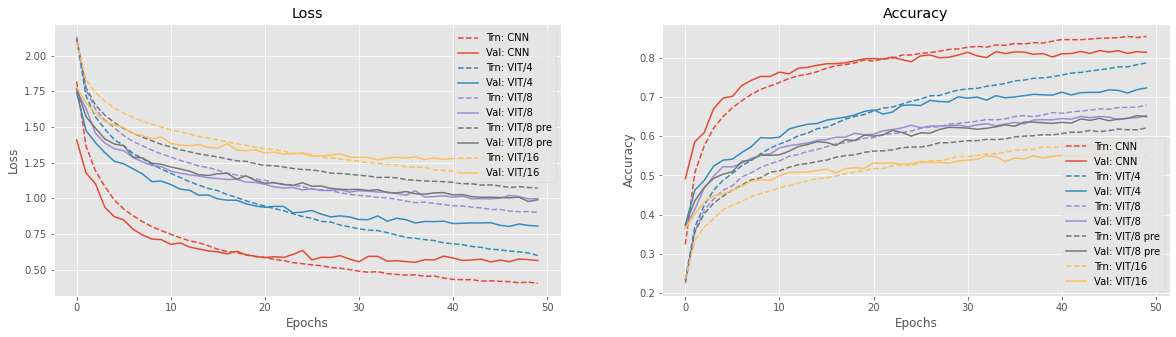

In [28]:
legends = ['CNN', 'VIT/4', 'VIT/8', 'VIT/8 pre', 'VIT/16']
histories = [history_cnn, history_vit_4x4, 
             history_vit_8x8, history_vit_8x8_pre, history_vit_16x16]

plot([(i.history['loss'], i.history['val_loss']) for i in histories], 
     [(i.history['sparse_categorical_accuracy'],
       i.history['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])

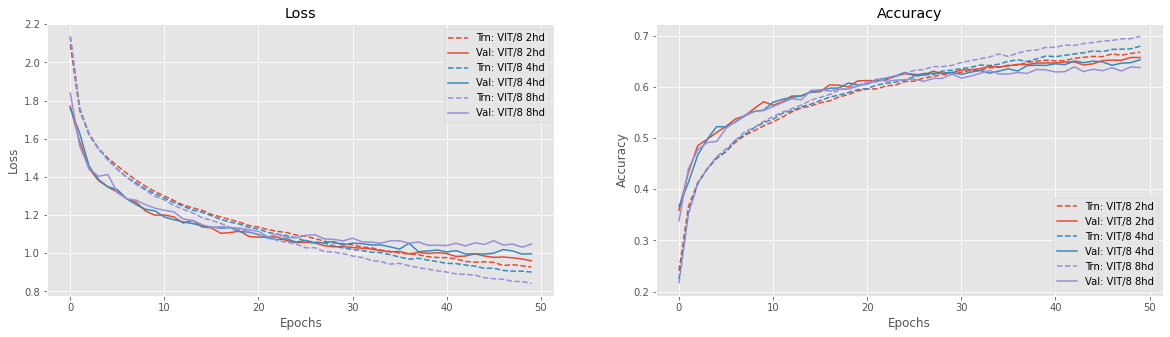

In [29]:
legends = ['VIT/8 2hd', 'VIT/8 4hd', 'VIT/8 8hd']
histories = [history_vit_8x8_2hd, history_vit_8x8, history_vit_8x8_8hd]

plot([(i.history['loss'], i.history['val_loss']) for i in histories], 
     [(i.history['sparse_categorical_accuracy'],
       i.history['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])

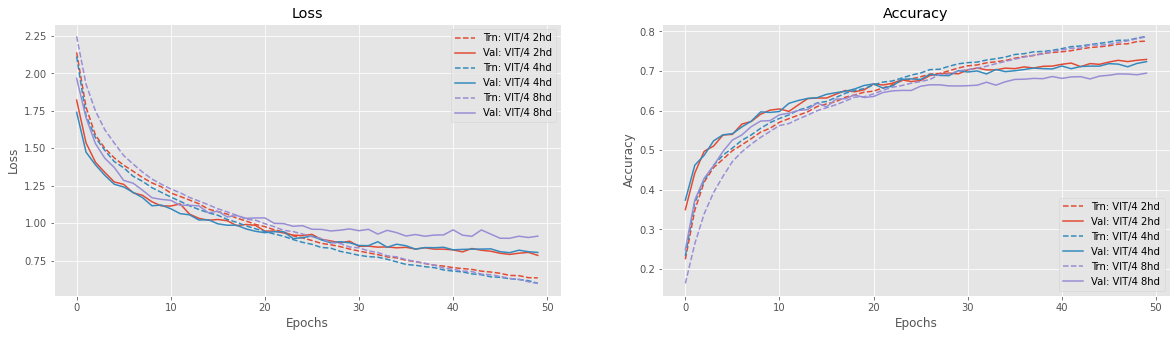

In [30]:
legends = ['VIT/4 2hd', 'VIT/4 4hd', 'VIT/4 8hd']
histories = [history_vit_4x4_2hd, history_vit_4x4, history_vit_4x4_8hd]

plot([(i.history['loss'], i.history['val_loss']) for i in histories], 
     [(i.history['sparse_categorical_accuracy'],
       i.history['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])

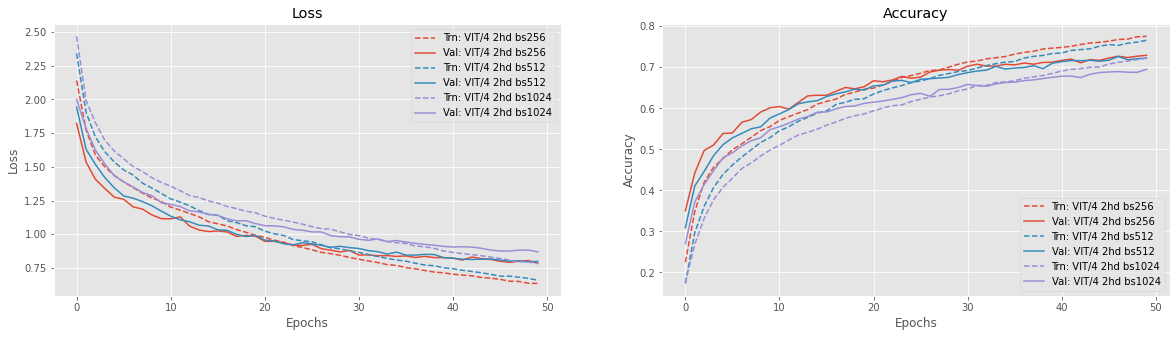

In [31]:
legends = ['VIT/4 2hd bs256', 'VIT/4 2hd bs512', 'VIT/4 2hd bs1024']
histories = [history_vit_4x4_2hd, history_vit_4x4_2hd_bs512, history_vit_4x4_2hd_bs1024]

plot([(i.history['loss'], i.history['val_loss']) for i in histories], 
     [(i.history['sparse_categorical_accuracy'],
       i.history['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])

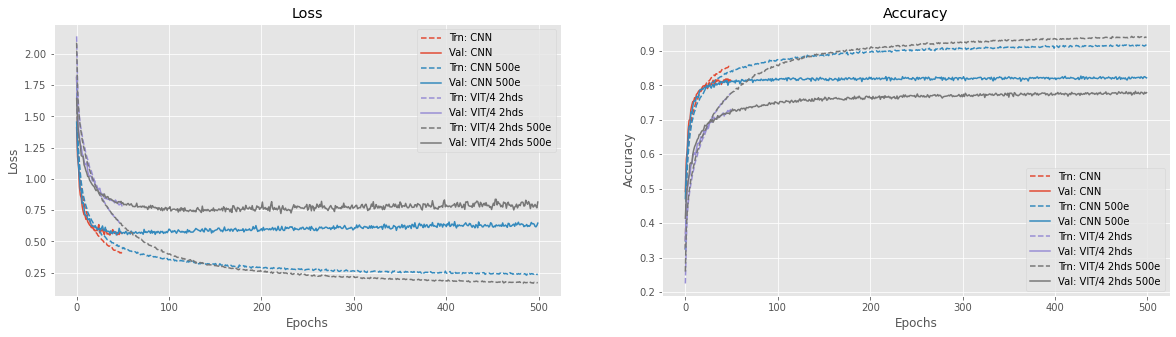

In [32]:
legends = ['CNN', 'CNN 500e', 'VIT/4 2hds', 'VIT/4 2hds 500e']
histories = [history_cnn, history_cnn_500epoch, 
             history_vit_4x4_2hd, history_vit_4x4_2hd_500epoch]

plot([(i.history['loss'], i.history['val_loss']) for i in histories], 
     [(i.history['sparse_categorical_accuracy'],
       i.history['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])